In [ ]:
from IPython.display import clear_output
import time

In [ ]:
# ! rm -rf movie_recommender/
# ! rm -rf experiments
# ! rm -rf plots/

In [ ]:
# ! git clone https://github.com/emmanuel-olateju/movie_recommender.git
# ! git clone -b optimize-dataloader --single-branch https://github.com/emmanuel-olateju/movie_recommender.git
# ! git clone -b add-optimized-trainer --single-branch https://github.com/emmanuel-olateju/movie_recommender.git
# ! git clone -b feature/model_load --single-branch https://github.com/emmanuel-olateju/movie_recommender.git
! git clone -b feature/movie_features --single-branch https://github.com/emmanuel-olateju/movie_recommender.git

Cloning into 'movie_recommender'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 176 (delta 118), reused 116 (delta 61), pack-reused 0 (from 0)
Receiving objects: 100% (176/176), 1.83 MiB | 5.94 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
import sys
sys.path.append("movie_recommender/modules")
from dataset_loader import MovieLensDataset_Base, MovieLensDataset_Optimized, GridSearch

In [ ]:
from google.colab import drive
drive.mount("drive/")

Mounted at drive/


In [ ]:
! mkdir experiments
# ! mkdir -p plots/pngs
# ! mkdir -p plots/pdfs

# Functions and Classes

In [ ]:
# @title Functions

from tqdm import tqdm

def make_representation(rating_list, vector_length):
  if len(rating_list) == 0:
    return np.zeros((vector_length))

  arr = np.array(rating_list)
  vector_pos = arr[:, 1].astype(int)
  rating_values = arr[:, 0]

  vector = np.zeros((vector_length,))
  vector[vector_pos] = rating_values

  return vector

def compute_loss_base_dataset(ds, U, V, BM, BN, lambda_, tau, gamma, mu, mode="train"):
    M = len(ds.user_train)
    N = len(ds.movie_train)

    rating_errors = []
    total_ratings = 0.0

    for m in range(M):
        user_ratings = ds.user_train[m] if mode == "train" else ds.user_test[m]
        if len(user_ratings) == 0:
            continue

        rated_idx = np.array([x[1] for x in user_ratings], dtype=int)
        r_m_rated = np.array([x[0] for x in user_ratings], dtype=float)

        pred_m_rated = mu + V[rated_idx] @ U[m, :] + BM[m] + BN[rated_idx]
        # pred_m_rated = mu + BM[m] + BN[rated_idx]
        rating_errors.append((r_m_rated - pred_m_rated) ** 2)
        total_ratings += len(rated_idx)

    if total_ratings == 0:
        # return float('inf'), float('inf')  # or 0, depending on preference
        return 0.0, 0.0

    rating_error_all = np.concatenate(rating_errors)
    rating_error = np.sum(rating_error_all)

    # RMSE is always just the data fit
    rmse = np.sqrt(rating_error / total_ratings) if total_ratings > 0 else 0.0

    # Loss differs by mode
    if mode == "train":
        users_norm = np.sum(U ** 2)
        movies_norm = np.sum(V ** 2)
        users_bias_squared = np.sum(BM ** 2)
        movies_bias_squared = np.sum(BN ** 2)

        loss = (lambda_ / 2) * rating_error + \
               (gamma / 2) * (users_bias_squared + movies_bias_squared) + \
               (tau / 2) * (users_norm + movies_norm)

    else:
        # Test loss: only data fit (no regularization)
        loss = (lambda_ / 2) * rating_error  # or even just rating_error

    return loss, rmse

def compute_loss_optimized_dataset(ds, U, V, BM, BN, lambda_, tau, gamma, mu, mode="train"):
    M, N = ds.user_movie_counts()

    rating_errors = []
    total_ratings = 0.0

    if mode == 'train':
      users_idx = dataset.users[dataset.train_idx]
      movies_idx = dataset.movies[dataset.train_idx]
      ratings = dataset.ratings[dataset.train_idx]
    else:
      users_idx = dataset.users[dataset.test_idx]
      movies_idx = dataset.movies[dataset.test_idx]
      ratings = dataset.ratings[dataset.test_idx]

    pred_m_rated = mu + np.sum(V[movies_idx] * U[users_idx], axis=1) + BM[users_idx] + BN[movies_idx]
    rating_errors = (ratings - pred_m_rated) ** 2
    total_ratings = len(rating_errors)

    if total_ratings == 0:
      return 0.0, 0.0

    rating_error = np.sum(rating_errors)

    # RMSE is always just the data fit
    rmse = np.sqrt(rating_error / total_ratings) if total_ratings > 0 else 0.0

    # Loss differs by mode
    if mode == "train":
      users_norm = np.sum(U ** 2)
      movies_norm = np.sum(V ** 2)
      users_bias_squared = np.sum(BM ** 2)
      movies_bias_squared = np.sum(BN ** 2)

      loss = (lambda_ / 2) * rating_error + \
              (gamma / 2) * (users_bias_squared + movies_bias_squared) + \
              (tau / 2) * (users_norm + movies_norm)

    else:
      # Test loss: only data fit (no regularization)
      loss = (lambda_ / 2) * rating_error  # or even just rating_error

    return loss, rmse

In [ ]:
# @title Experiment Class

from typing import List

import yaml
import numpy as np


class Experiment:

  def __init__(self, name, dir, description, baseline=None):
    self.name = name
    self.dir = dir
    self.description = description
    self.parameters = dict()
    self.baseline = baseline

  def update_param(self, parameter: 'Parameter'):
    var_name = parameter.get_var_name()
    parameter_class = parameter.get_parameter_class()
    value = parameter.get_value()

    assert isinstance(
        value,
        (
            int, float, str, dict, list,
            np.ndarray, torch.tensor, None
        )
    )

    if (parameter_class is None) or (parameter_class.lower() == 'global'):
      self.parameters[var_name] = value
      return

    if parameter_class not in self.parameters:
      self.parameters[parameter_class] = dict()
    self.parameters[parameter_class][var_name] = value

  def save(self):
    experiment_dict = {
        'name': self.name,
        'baseline': self.baseline,
        'description': self.description,
        'parameters': self.parameters,
    }

    with open(self.dir, "w") as f:
      yaml.dump(experiment_dict, f, default_flow_style=False)

    print(f"Model saved to {self.dir}")

  def add_params(self, parameters: List['Parameter']):

    for parameter in parameters:
      self.update_param(parameter)


class Parameter:

  def __init__(self, value, var_name, parameter_class):
    self.__var_name = var_name
    self.__value = value
    self.__parameter_class = parameter_class

  def get_var_name(self):
    return self.__var_name

  def get_parameter_class(self):
    return self.__parameter_class

  def get_value(self):
    return self.__value

  def set_value(self, value):
    self.__value = value

  def set_var_name(self, var_name):
    self.__var_name = var_name

  def set_parameter_class(self, parameter_class):
    self.__parameter_class = parameter_class

# Data set plots

In [ ]:
DATASET_DIR = "drive/MyDrive/datasets/ML_@_SCALE/ratings.csv"
dataset = MovieLensDataset_Optimized(DATASET_DIR)

100%|██████████| 32000204/32000204 [01:05<00:00, 487824.19it/s]


#### Movie Ratings Degree Distribution
 - Test for Power-law presenece and scale

In [ ]:
import numpy as np

M, N = dataset.user_movie_counts()
no_ratings_per_movie = np.bincount(dataset.movies, minlength=N)
no_ratings_per_user = np.bincount(dataset.users, minlength=M)

movie_rating_rank, movie_rating_frequency = np.unique(no_ratings_per_movie, return_counts=True)
user_rating_rank, user_rating_frequency = np.unique(no_ratings_per_user, return_counts=True)

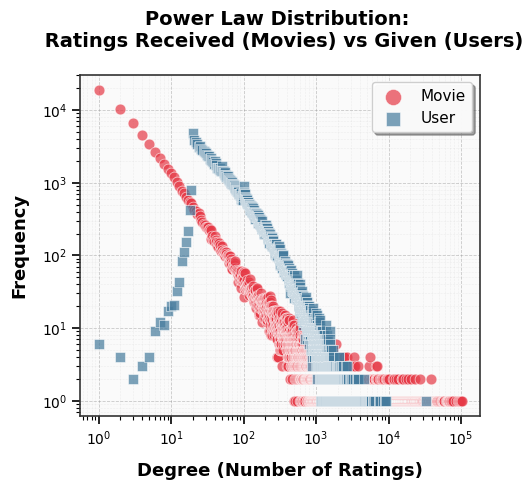

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with better size and DPI
fig, ax = plt.subplots(figsize=(5, 5))

# Define beautiful colors
movie_color = '#E63946'  # Vibrant red
user_color = '#457B9D'   # Deep blue

# Plot with enhanced styling
scatter1 = ax.scatter(movie_rating_rank, movie_rating_frequency,
                      label="Movie",
                      color=movie_color,
                      marker="o",
                      s=60,
                      alpha=0.7,
                      edgecolors='white',
                      linewidth=0.5)

scatter2 = ax.scatter(user_rating_rank, user_rating_frequency,
                      label="User",
                      color=user_color,
                      marker="s",
                      s=50,
                      alpha=0.7,
                      edgecolors='white',
                      linewidth=0.5)

# Set log scales
ax.set_xscale("log")
ax.set_yscale("log")

# Enhanced labels and title
ax.set_xlabel("Degree (Number of Ratings)", fontsize=13, fontweight='bold', labelpad=10)
ax.set_ylabel("Frequency", fontsize=13, fontweight='bold', labelpad=10)
ax.set_title("Power Law Distribution: \n Ratings Received (Movies) vs Given (Users)",
             fontsize=14, fontweight='bold', pad=20)

# Beautiful legend
legend = ax.legend(fontsize=11,
                   frameon=True,
                   shadow=True,
                   fancybox=True,
                   loc='best',
                   markerscale=1.5)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.95)

# Enhanced grid
ax.grid(True, which="both", linestyle='--', linewidth=0.6, alpha=0.4, color='gray')
ax.set_axisbelow(True)

# Add minor grid for log scale
ax.grid(True, which="minor", linestyle=':', linewidth=0.4, alpha=0.2, color='gray')

# Styling for spines
for spine in ax.spines.values():
    spine.set_linewidth(1.2)
    spine.set_edgecolor('#333333')

# Better tick labels
ax.tick_params(axis='both', which='major', labelsize=10, width=1.2, length=6)
ax.tick_params(axis='both', which='minor', width=0.8, length=3)

# Set background color
ax.set_facecolor('#FAFAFA')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig("plots/pngs/power_law.png", format="png", dpi=150, bbox_inches='tight', facecolor='white')
plt.savefig("plots/pdfs/power_law.pdf", format="pdf", dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

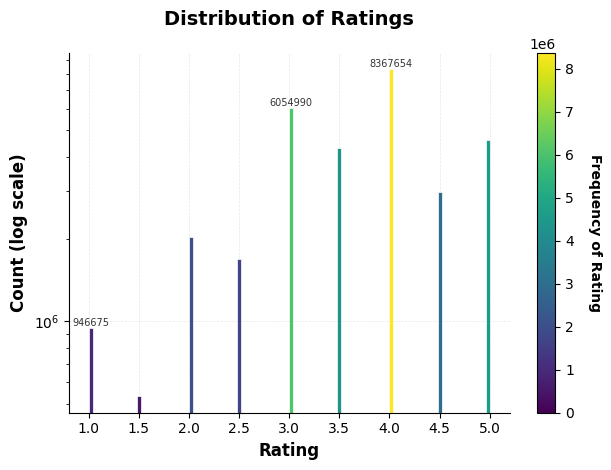

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create histogram data
counts, bins, patches = plt.hist(dataset.ratings, bins=100)

# Create color map based on counts
norm = plt.Normalize(counts.min(), counts.max())
colors = plt.cm.viridis(norm(counts))

# Clear and recreate with colored bars
plt.clf()
n, bins, patches = plt.hist(dataset.ratings, bins=100)

# Apply colors to each bar
for count, patch in zip(n, patches):
    patch.set_facecolor(plt.cm.viridis(norm(count)))
    patch.set_edgecolor('white')
    patch.set_linewidth(0.5)

# Add count labels on top of bars
for i, (count, patch) in enumerate(zip(n, patches)):
    if count > 0:  # Only show label if bar has data
        height = patch.get_height()
        # Only label every few bars to avoid overcrowding
        if i % 10 == 0 or count == n.max():
            plt.text(patch.get_x() + patch.get_width()/2., height,
                    f'{int(count)}',
                    ha='center', va='bottom', fontsize=7,
                    rotation=0, alpha=0.8)

plt.yscale('log')
plt.xlabel('Rating', fontsize=12, fontweight='bold')
plt.ylabel('Count (log scale)', fontsize=12, fontweight='bold')
plt.title('Distribution of Ratings', fontsize=14, fontweight='bold', pad=20)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Frequency of Rating', rotation=270, labelpad=20, fontsize=10, fontweight='bold')

# Style improvements
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
plt.gca().set_axisbelow(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("plots/pngs/rating_distributions.png", format="png", dpi=100, bbox_inches='tight')
plt.savefig("plots/pdfs/rating_distributions.pdf", format="pdf", dpi=100, bbox_inches='tight')
plt.show()

#### Rating Statistics By User

In [ ]:
dataset = MovieLensDataset_Base(DATASET_DIR)

100%|██████████| 32000204/32000204 [01:40<00:00, 318469.99it/s]


In [ ]:
from tqdm import tqdm

M, N = dataset.shape
mean_rating, rating_variance, n_rating = [], [], []

for user_key, user_idx in tqdm(dataset.users_map.items(), total=M):

  user_representation = np.array(dataset.user_ratings[user_idx])

  mean = np.mean(user_representation[:, 0]).item()
  variance = np.var(user_representation[:, 0]).item()

  n_rating.append(len(user_representation))
  mean_rating.append(mean)
  rating_variance.append(variance)

100%|██████████| 200948/200948 [00:31<00:00, 6375.65it/s]


In [ ]:
# from tqdm import tqdm

# mean_rating, rating_variance, n_rating = [], [], []

# for user in tqdm(range(M), total=M):
#   user_trait = np.where(dataset.users == user)[0]
#   user_trait = dataset.ratings[user_trait]

#   mean = np.mean(user_trait).item()
#   variance = np.var(user_trait).item()

#   n_rating.append(len(user_trait))
#   mean_rating.append(mean)
#   rating_variance.append(variance)

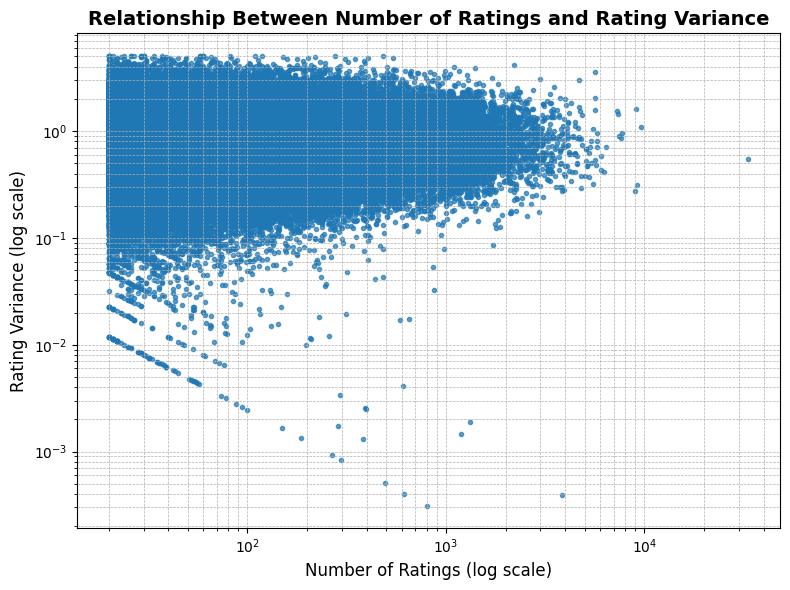

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(n_rating, rating_variance, marker=".", alpha=0.7, rasterized=True)

# Logarithmic scales
plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Number of Ratings (log scale)", fontsize=12)
plt.ylabel("Rating Variance (log scale)", fontsize=12)
plt.title("Relationship Between Number of Ratings and Rating Variance", fontsize=14, fontweight='bold')

# Grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Optional: add minor ticks
plt.minorticks_on()

# Optional: adjust layout
plt.tight_layout()

# Show the plot
# plt.show()

plt.savefig("plots/pngs/no_user_ratings_&_rating_variance.png", format="png", dpi=100)  # high-res SVG
plt.savefig("plots/pdfs/no_user_ratings_&_rating_variance.pdf", format="pdf", dpi=100)  # high-res SVG
# plt.savefig("plots/svgs/no_user_ratings_&_rating_variance.svg", format="svg", dpi=100)  # high-res SVG

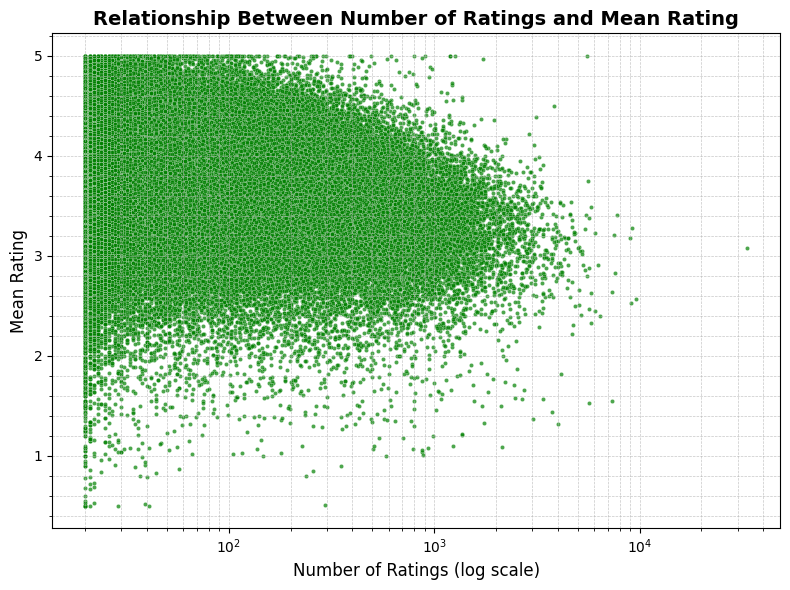

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    n_rating, mean_rating, marker=".",
    alpha=0.7, color='green', edgecolors='w',
    linewidth=0.2, rasterized=True
)

# Logarithmic x-scale
plt.xscale("log")

# Labels and title
plt.xlabel("Number of Ratings (log scale)", fontsize=12)
plt.ylabel("Mean Rating", fontsize=12)
plt.title("Relationship Between Number of Ratings and Mean Rating", fontsize=14, fontweight='bold')

# Grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Optional: add minor ticks
plt.minorticks_on()

# Optional: adjust layout
plt.tight_layout()

# Show the plot
# plt.show()

plt.savefig("plots/pngs/no_user_ratings_&_mean_rating.png", format="png", dpi=100)  # high-res SVG
plt.savefig("plots/pdfs/no_user_ratings_&_mean_rating.pdf", format="pdf", dpi=100)  # high-res SVG
# plt.savefig("plots/svgs/no_user_ratings_&_mean_rating.svg", format="svg", dpi=100)  # high-res SVG

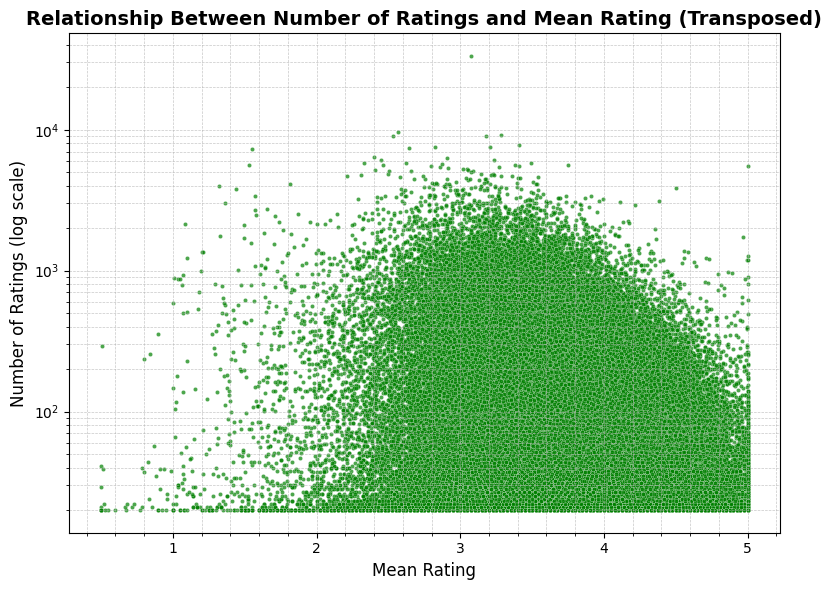

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    mean_rating, n_rating, marker=".",
    alpha=0.7, color='green', edgecolors='w',
    linewidth=0.2, rasterized=True
)

# Logarithmic x-scale
plt.yscale("log")

# Labels and title
plt.ylabel("Number of Ratings (log scale)", fontsize=12)
plt.xlabel("Mean Rating", fontsize=12)
plt.title("Relationship Between Number of Ratings and Mean Rating (Transposed)", fontsize=14, fontweight='bold')

# Grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Optional: add minor ticks
plt.minorticks_on()

# Optional: adjust layout
plt.tight_layout()

# Show the plote
# plt.show()

plt.savefig("plots/pngs/mean_rating_&_no_user_ratings.png", format="png", dpi=100)  # high-res SVG
plt.savefig("plots/pdfs/mean_rating_&_no_user_ratings.pdf", format="pdf", dpi=100)  # high-res SVG
# plt.savefig("plots/svgs/mean_rating_&_no_user_ratings.svg", format="svg", dpi=100)  # high-res SVG

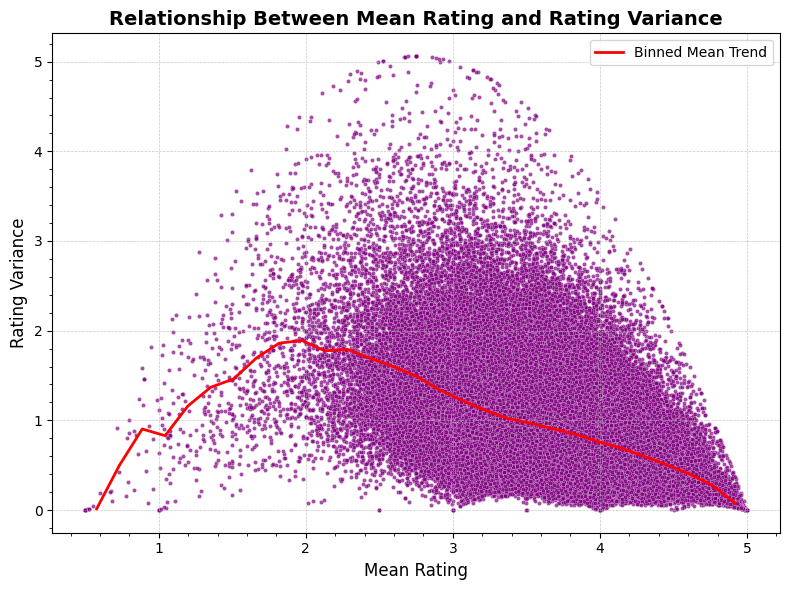

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    mean_rating, rating_variance, marker=".", alpha=0.7,
    color='purple', edgecolors='w',
    linewidth=0.2, rasterized=True
)

# Labels and title
plt.xlabel("Mean Rating", fontsize=12)
plt.ylabel("Rating Variance", fontsize=12)
plt.title("Relationship Between Mean Rating and Rating Variance", fontsize=14, fontweight='bold')

# Grid for readability
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.minorticks_on()

# Optional: trend line using binned mean variance
bins = np.linspace(min(mean_rating), max(mean_rating), 30)
bin_means, _, _ = binned_statistic(mean_rating, rating_variance, statistic='mean', bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, bin_means, color='red', linestyle='-', linewidth=2, label='Binned Mean Trend')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
# plt.show()


plt.savefig("plots/pngs/mean_rating_&_rating_variance.png", format="png", dpi=100)  # high-res SVG
plt.savefig("plots/pdfs/mean_rating_&_rating_variance.pdf", format="pdf", dpi=100)  # high-res SVG
# plt.savefig("plots/svgs/mean_rating_&_rating_variance.svg", format="svg", dpi=100)  # high-res SVG

# ALS Biases Only

In [ ]:
# DATASET_DIR = "drive/MyDrive/datasets/ML_@_SCALE/ratings_small.csv"
DATASET_DIR = "drive/MyDrive/datasets/ML_@_SCALE/ratings.csv"

#### Grid Search

In [ ]:
# @title Parameter Configurations {"run":"auto","vertical-output":true}

import os
import torch

name = 'v0.1.1' # @param {type:'string'}

save_folder = f'experiments/{name}'
save_dir = f'{save_folder}/{name}.yaml'
description = 'Biases update: hyperparameter grid search on full (32M) dataset - Make latent dimension 15' # @param {type:'string'}
baseline_exp = "v0.1" # @param {type: 'string'}
if os.path.exists(save_folder) is False:
  os.makedirs(save_folder)
experiment = Experiment(
    name,
    save_dir,
    description,
    baseline_exp
)

n_epochs = 50 # @param
eval_inter = 5 # @param
features = False # @param {type: 'boolean'}
only_biases = True # @param {type: 'boolean'}

n_epochs_param = Parameter(
    n_epochs,
    'Epochs',
    'Hyperparameters'
)
eval_inter_param = Parameter(
    eval_inter,
    "Evaluation-Interval",
    "Hyperparameters"
)
features_param = Parameter(
    features,
    'use_genre_features',
    'Hyperparameters'
)
only_biases_param = Parameter(
    only_biases,
    'only_biases',
    'Hyperparameters'
)

experiment.add_params([
    n_epochs_param,
    eval_inter_param,
    features_param,
    only_biases_param
])

In [ ]:
import os
os.environ["MKL_NUM_THREADS"] = "2"

In [ ]:
# @title Train-Model

from itertools import product

gamma = [0.0, 0.25, 0.5, 0.75, 1.0]
lambda_ = [1.0]
tau = [0.5]
latent_dim = [12]
eta = [0.0]

param_grid = {
    'test_size': [0.1],
    'latent_dim': latent_dim,
    'n_iter': [n_epochs_param.get_value()],
    'eval_inter': [eval_inter_param.get_value()],
    'lambda_': lambda_,
    'tau': tau,
    'gamma': gamma,
    'eta': eta,
    'use_features': [features_param.get_value()],
    'biases_alone': [only_biases_param.get_value()],
    'verbose': [True]
}

dataset = MovieLensDataset_Optimized(DATASET_DIR)
grid_search = GridSearch(param_grid)
grid_search = grid_search.fit(dataset)

best_params = Parameter(
    grid_search.best_params(),
    'best_params',
    'Hyperparameters'
)
best_score = Parameter(
    grid_search.best_score().item(),
    'NLL',
    'Performance'
)
best_rmse = Parameter(
    grid_search.best_rmse().item(),
    'RMSE',
    'Performance'
)
param_grid = Parameter(
    param_grid,
    'Parameter_Space',
    'Grid_Search'
)

experiment.add_params([
    best_params,
    best_score,
    best_rmse,
    param_grid
])

experiment.save()

Grid Search: 100%|██████████| 5/5 [58:43<00:00, 704.77s/it]

Model saved to experiments/v0.1.1/v0.1.1.yaml


In [ ]:
! zip -r AMLAS_Experiments.zip  experiments/

from google.colab import files
files.download('AMLAS_Experiments.zip')

  adding: experiments/ (stored 0%)
  adding: experiments/v0.1.1/ (stored 0%)
  adding: experiments/v0.1.1/v0.1.1.yaml (deflated 60%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Training

In [ ]:
# @title Parameter Configurations {"run":"auto","vertical-output":true}

import os
import torch

name = 'v0.2' # @param {type:'string'}

save_folder = f'experiments/{name}'
save_dir = f'{save_folder}/{name}.yaml'
description = 'Biases update: Train with best parameters from grid search and save artifacts' # @param {type:'string'}
baseline_exp = "v0.1, v0.1.1" # @param {type: 'string'}
if os.path.exists(save_folder) is False:
  os.makedirs(save_folder)
experiment = Experiment(
    name,
    save_dir,
    description,
    baseline_exp
)

latent_dim = 12 # @param
K = latent_dim
lambda_ = 1.0 # @param
gamma = 0.0 # @param
tau = 0.5 # @param
eta = 0.0 # @param
n_epochs = 50 # @param
eval_inter = 5 # @param
batch_size = 30000 # @param
features = False # @param {type: 'boolean'}
only_biases = True # @param {type: 'boolean'}

latent_param = Parameter(
    K,
    'embedding_dim',
    'Hyperparameters'
)
lambda_param = Parameter(
    lambda_,
    'residuals_regularizer_lambda',
    'Hyperparameters'
)
gamma_param = Parameter(
    gamma,
    'biases_regularizer_gamma',
    'Hyperparameters'
)
tau_param = Parameter(
    tau,
    'embeddings_regularizer_tau',
    'Hyperparameters'
)
eta_param = Parameter(
    eta,
    'embeddings_regularizer_eta',
    'Hyperparameters'
)
n_epochs_param = Parameter(
    n_epochs,
    'Epochs',
    'Hyperparameters'
)
eval_inter_param = Parameter(
    eval_inter,
    "Evaluation-Interval",
    "Hyperparameters"
)
batch_size_param = Parameter(
    batch_size,
    "Batch-Size",
    "Hyperparamters"
)
features_param = Parameter(
    features,
    'use_genre_features',
    'Hyperparameters'
)
only_biases_param = Parameter(
    only_biases,
    'only_biases',
    'Hyperparameters'
)

experiment.add_params([
    lambda_param,
    gamma_param,
    tau_param,
    eta_param,
    n_epochs_param,
    eval_inter_param,
    batch_size_param,
    features_param,
    only_biases_param
])

100%|██████████| 31475072/31475072 [00:12<00:00, 2429518.21it/s]


Building lookup tables ...


Building lookups: 100%|██████████| 28327503/28327503 [00:19<00:00, 1422060.42it/s]


Lookup tables built
Training without features
Updating Bias Alone


  2%|▏         | 1.00/50.0 [00:16<13:20, 16.3s/it]

Epoch 0: Train Loss = 9335375.8040, RMSE: 0.8111 | Test Loss = 1003559.8722, RMSE: 0.8193


 12%|█▏        | 6.00/50.0 [01:30<10:57, 14.9s/it]

Epoch 5: Train Loss = 8993128.1578, RMSE: 0.7961 | Test Loss = 967053.0692, RMSE: 0.8042


 22%|██▏       | 11.0/50.0 [02:45<09:43, 15.0s/it]

Epoch 10: Train Loss = 8993053.1695, RMSE: 0.7961 | Test Loss = 967049.7444, RMSE: 0.8042


 32%|███▏      | 16.0/50.0 [03:59<08:23, 14.8s/it]

Epoch 15: Train Loss = 8992988.7662, RMSE: 0.7961 | Test Loss = 967046.3609, RMSE: 0.8042


 42%|████▏     | 21.0/50.0 [05:14<07:14, 15.0s/it]

Epoch 20: Train Loss = 8992927.3461, RMSE: 0.7961 | Test Loss = 967043.0563, RMSE: 0.8042


 52%|█████▏    | 26.0/50.0 [06:27<05:54, 14.8s/it]

Epoch 25: Train Loss = 8992868.7664, RMSE: 0.7961 | Test Loss = 967039.8541, RMSE: 0.8042


 62%|██████▏   | 31.0/50.0 [07:41<04:41, 14.8s/it]

Epoch 30: Train Loss = 8992812.8959, RMSE: 0.7961 | Test Loss = 967036.7517, RMSE: 0.8042


 72%|███████▏  | 36.0/50.0 [08:55<03:26, 14.8s/it]

Epoch 35: Train Loss = 8992759.6092, RMSE: 0.7961 | Test Loss = 967033.7454, RMSE: 0.8042


 82%|████████▏ | 41.0/50.0 [10:13<02:18, 15.4s/it]

Epoch 40: Train Loss = 8992708.7868, RMSE: 0.7961 | Test Loss = 967030.8320, RMSE: 0.8042


 92%|█████████▏| 46.0/50.0 [11:27<00:59, 14.8s/it]

Epoch 45: Train Loss = 8992660.3148, RMSE: 0.7961 | Test Loss = 967028.0082, RMSE: 0.8042


100%|██████████| 50.0/50.0 [12:26<00:00, 14.9s/it]



END: Train Loss = 8992623.1562, RMSE: 0.796110 | Val Loss = 967025.8117, RMSE: 0.804236
Loss Reduction: Train 4938773.8206, Val 502689.2372
Model saved to experiments/v0.2/v0.2.yaml


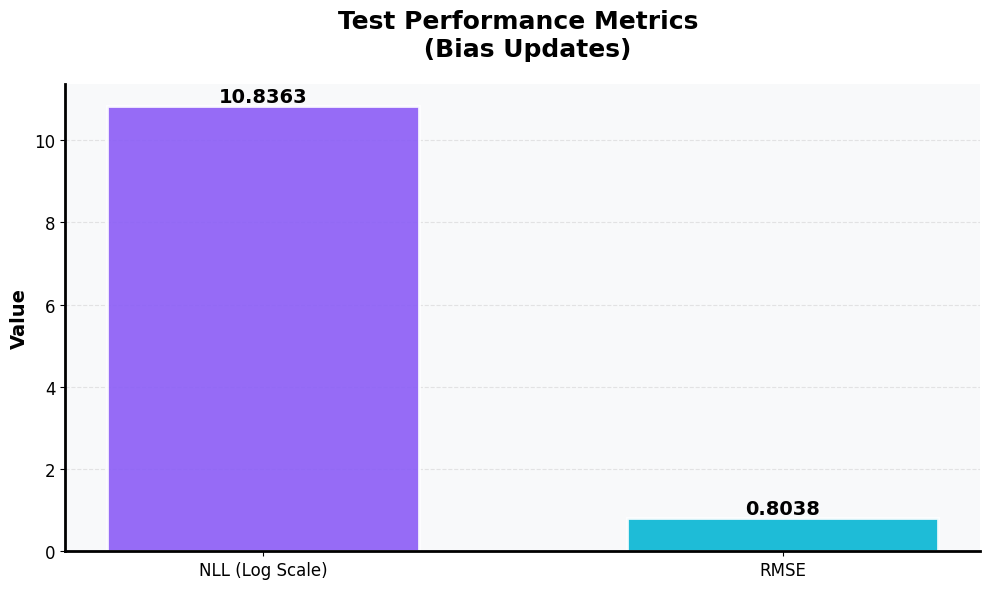

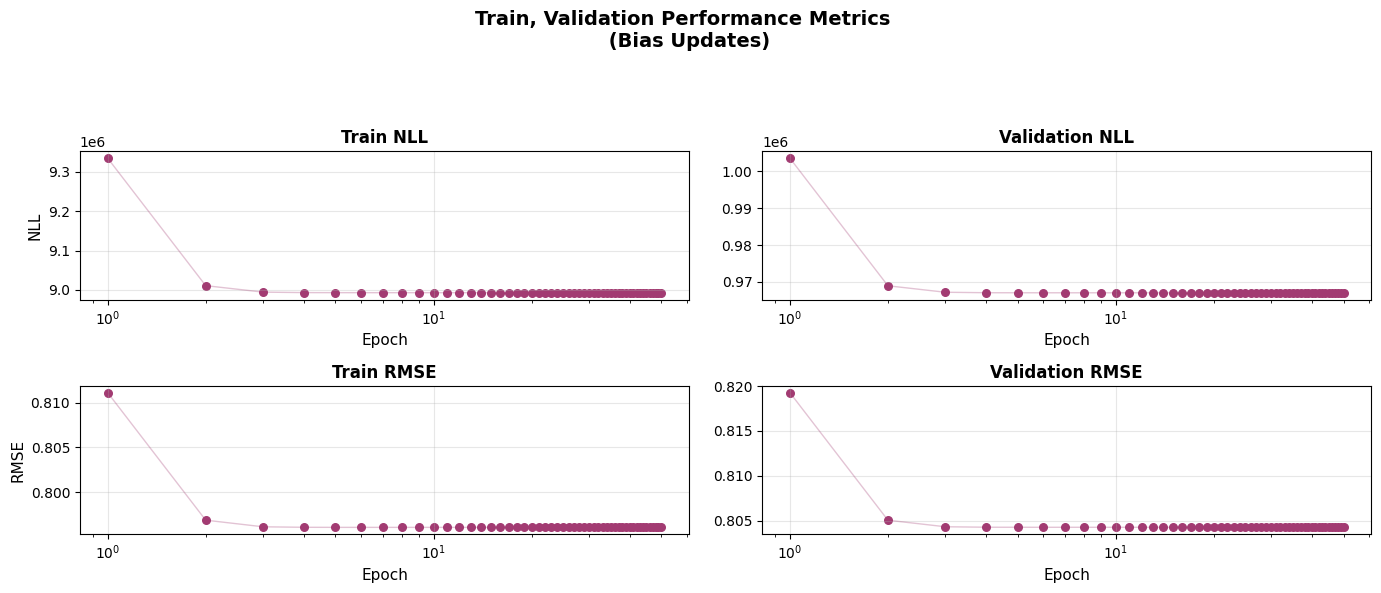

In [ ]:
dataset = MovieLensDataset_Optimized(DATASET_DIR)
history = dataset.train(
    test_size=0.1,
    latent_dim=latent_param.get_value(),
    n_iter=n_epochs_param.get_value(),
    eval_inter=eval_inter_param.get_value(),
    lambda_=lambda_param.get_value(),
    tau=1, gamma=tau_param.get_value(),
    eta=eta_param.get_value(),
    use_features=features_param.get_value(),
    biases_alone=only_biases_param.get_value(),
    verbose=True
)

test_loss, test_rmse = dataset.compute_loss(mode="test")
test_loss_param = Parameter(test_loss.item(), "test_NLL", "Performance")
test_rmse_param = Parameter(test_rmse.item(), "test_RMSE", "Performance")
experiment.add_params([
    test_loss_param,
    test_rmse_param
])

experiment.save()


dataset.test_performance(
    save_folder=save_folder,
    save_name="bias_updates_test_performance",
    title="Test Performance Metrics \n (Bias Updates)"
)
dataset.train_val_performance(
    **history,
    save_dir=f'{save_folder}',
    save_name='bias_updates_train+val_performance',
    title='Train, Validation Performance Metrics \n (Bias Updates)'
)

if features_param.get_value():
  np.savez(
      f"{save_folder}/model_(hyper)parameters_optimizedTrainer.npz",
      # U=dataset.U, V=dataset.V,
      BM=dataset.BM, BN=dataset.BN,
      mu=dataset.mu, lambda_=dataset.lambda_,
      gamma=dataset.gamma, tau=dataset.tau,
      eta=dataset.eta,
      W=dataset.W
  )
else:
  np.savez(
      f"{save_folder}/model_(hyper)parameters_optimizedTrainer.npz",
      # U=dataset.U, V=dataset.V,
      BM=dataset.BM, BN=dataset.BN,
      mu=dataset.mu, lambda_=dataset.lambda_,
      gamma=dataset.gamma, tau=dataset.tau,
      eta=dataset.eta
  )
np.savez(f"{save_folder}/optimizedTrainer_history.npz", **history)

# ALS (Biases + Embeddings)

In [ ]:
# DATASET_DIR = "drive/MyDrive/datasets/ML_@_SCALE/ratings_small.csv"
DATASET_DIR = "drive/MyDrive/datasets/ML_@_SCALE/ratings.csv"
MOVIES_DIR = "drive/MyDrive/datasets/ML_@_SCALE/movies.csv"

#### Grid Search

In [ ]:
# @title Parameter Configurations {"run":"auto","vertical-output":true}

import os
import torch

name = 'v1.0' # @param {type:'string'}

save_folder = f'experiments/{name}'
save_dir = f'{save_folder}/{name}.yaml'
description = 'Biases + update: hyperparameter grid search on 32M dataset: Vary Tau in Grid-Search' # @param {type:'string'}
baseline_exp = "v1.1" # @param {type: 'string'}
if os.path.exists(save_folder) is False:
  os.makedirs(save_folder)
experiment = Experiment(
    name,
    save_dir,
    description,
    baseline_exp
)

n_epochs = 50 # @param
eval_inter = 5 # @param
features = True # @param {type: 'boolean'}
only_biases = False # @param {type: 'boolean'}

n_epochs_param = Parameter(
    n_epochs,
    'Epochs',
    'Hyperparameters'
)
eval_inter_param = Parameter(
    eval_inter,
    "Evaluation-Interval",
    "Hyperparameters"
)
features_param = Parameter(
    features,
    'use_genre_features',
    'Hyperparameters'
)
only_biases_param = Parameter(
    only_biases,
    'only_biases',
    'Hyperparameters'
)

experiment.add_params([
    n_epochs_param,
    eval_inter_param,
    features_param,
    only_biases_param
])

In [ ]:
import os
os.environ["MKL_NUM_THREADS"] = "2"

In [ ]:
# @title Train-Model

from itertools import product

gamma = [0.0]
lambda_ = [1.0]
tau = [0.25]
latent_dim = [10]
eta = [0.0]

param_grid = {
    'test_size': [0.1],
    'latent_dim': latent_dim,
    'n_iter': [n_epochs_param.get_value()],
    'eval_inter': [eval_inter_param.get_value()],
    'lambda_': lambda_,
    'tau': tau,
    'gamma': gamma,
    'eta': eta,
    'use_features': [features_param.get_value()],
    'biases_alone': [only_biases_param.get_value()],
    'verbose': [True]
}

dataset = MovieLensDataset_Optimized(DATASET_DIR)
grid_search = GridSearch(param_grid)
grid_search = grid_search.fit(dataset)

best_params = Parameter(
    grid_search.best_params(),
    'best_params',
    'Hyperparameters'
)
best_score = Parameter(
    grid_search.best_score().item(),
    'NLL',
    'Performance'
)
best_rmse = Parameter(
    grid_search.best_rmse().item(),
    'RMSE',
    'Performance'
)
param_grid = Parameter(
    param_grid,
    'Parameter_Space',
    'Grid_Search'
)

experiment.add_params([
    best_params,
    best_score,
    best_rmse,
    param_grid
])

experiment.save()

Grid Search: 100%|██████████| 7/7 [1:34:58<00:00, 814.03s/it]

Model saved to experiments/v2.0/v2.0.yaml


In [ ]:
! zip -r AMLAS_Experiments.zip  experiments/

from google.colab import files
files.download('AMLAS_Experiments.zip')

  adding: experiments/ (stored 0%)
  adding: experiments/v1.0/ (stored 0%)
  adding: experiments/v1.0/v1.0.yaml (deflated 60%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Training

In [ ]:
# @title Parameter Configurations {"run":"auto","vertical-output":true}

import os
import torch

name = 'v2.1' # @param {type:'string'}

save_folder = f'experiments/{name}'
save_dir = f'{save_folder}/{name}.yaml'
description = 'Biases + Latent Factors + Features Update: Train with parameters from Grid Search of v1.0, reduce latent_dim (K) to 2' # @param {type:'string'}
baseline_exp = "v1.0, v2.1" # @param {type: 'string'}
if os.path.exists(save_folder) is False:
  os.makedirs(save_folder)
experiment = Experiment(
    name,
    save_dir,
    description,
    baseline_exp
)

latent_dim = 2 # @param
K = latent_dim
lambda_ = 1.0 # @param
gamma = 0.0 # @param
tau = 0.25 # @param
eta = 0.25 # @param
n_epochs = 50 # @param
eval_inter = 5 # @param
batch_size = 30000 # @param
features = True # @param {type: 'boolean'}
only_biases = False # @param {type: 'boolean'}

latent_param = Parameter(
    K,
    'embedding_dim',
    'Hyperparameters'
)
lambda_param = Parameter(
    lambda_,
    'residuals_regularizer_lambda',
    'Hyperparameters'
)
gamma_param = Parameter(
    gamma,
    'biases_regularizer_gamma',
    'Hyperparameters'
)
tau_param = Parameter(
    tau,
    'embeddings_regularizer_tau',
    'Hyperparameters'
)
eta_param = Parameter(
    eta,
    'embeddings_regularizer_eta',
    'Hyperparameters'
)
n_epochs_param = Parameter(
    n_epochs,
    'Epochs',
    'Hyperparameters'
)
eval_inter_param = Parameter(
    eval_inter,
    "Evaluation-Interval",
    "Hyperparameters"
)
batch_size_param = Parameter(
    batch_size,
    "Batch-Size",
    "Hyperparamters"
)
features_param = Parameter(
    features,
    'use_genre_features',
    'Hyperparameters'
)
only_biases_param = Parameter(
    only_biases,
    'only_biases',
    'Hyperparameters'
)

experiment.add_params([
    lambda_param,
    gamma_param,
    tau_param,
    eta_param,
    n_epochs_param,
    eval_inter_param,
    batch_size_param,
    features_param,
    only_biases_param
])

In [ ]:
import os
os.environ["MKL_NUM_THREADS"] = "2"

100%|██████████| 32000204/32000204 [01:07<00:00, 475628.66it/s]


Loading movie features...


Processing movie features: 87585it [00:00, 238802.11it/s]


Loaded 19 unique features (genres)
Features mapped for 76766/83146 movies


100%|██████████| 31475072/31475072 [00:13<00:00, 2318845.34it/s]


Building lookup tables ...


Building lookups: 100%|██████████| 28329241/28329241 [00:22<00:00, 1261484.27it/s]


Lookup tables built
Using features: 19 features with dim 2
Updating Bias + User/Movie Embeeding


  2%|▏         | 1.00/50.0 [00:36<30:02, 36.8s/it]

Epoch 0 [with features]: Train Loss = 9322785.8883, RMSE: 0.8104 | Test Loss = 1014087.3772, RMSE: 0.8238


 12%|█▏        | 6.00/50.0 [03:42<27:11, 37.1s/it]

Epoch 5 [with features]: Train Loss = 7974286.0958, RMSE: 0.7480 | Test Loss = 884474.3497, RMSE: 0.7694


 22%|██▏       | 11.0/50.0 [06:49<24:17, 37.4s/it]

Epoch 10 [with features]: Train Loss = 7948385.8161, RMSE: 0.7467 | Test Loss = 882698.5806, RMSE: 0.7686


 32%|███▏      | 16.0/50.0 [09:59<21:24, 37.8s/it]

Epoch 15 [with features]: Train Loss = 7936580.6945, RMSE: 0.7462 | Test Loss = 881897.9819, RMSE: 0.7683


 42%|████▏     | 21.0/50.0 [13:06<18:04, 37.4s/it]

Epoch 20 [with features]: Train Loss = 7929577.1880, RMSE: 0.7459 | Test Loss = 881538.5380, RMSE: 0.7681


 52%|█████▏    | 26.0/50.0 [16:12<14:59, 37.5s/it]

Epoch 25 [with features]: Train Loss = 7925939.2533, RMSE: 0.7458 | Test Loss = 881366.9093, RMSE: 0.7680


 62%|██████▏   | 31.0/50.0 [19:18<11:46, 37.2s/it]

Epoch 30 [with features]: Train Loss = 7923740.8172, RMSE: 0.7457 | Test Loss = 881269.6682, RMSE: 0.7680


 72%|███████▏  | 36.0/50.0 [22:23<08:38, 37.0s/it]

Epoch 35 [with features]: Train Loss = 7922304.1530, RMSE: 0.7457 | Test Loss = 881213.4464, RMSE: 0.7680


 82%|████████▏ | 41.0/50.0 [25:30<05:35, 37.2s/it]

Epoch 40 [with features]: Train Loss = 7921325.8829, RMSE: 0.7457 | Test Loss = 881181.9771, RMSE: 0.7680


 92%|█████████▏| 46.0/50.0 [28:35<02:28, 37.1s/it]

Epoch 45 [with features]: Train Loss = 7920639.8067, RMSE: 0.7457 | Test Loss = 881165.5335, RMSE: 0.7679


100%|██████████| 50.0/50.0 [31:03<00:00, 37.3s/it]



END: Train Loss = 7920232.9625, RMSE: 0.745669 | Val Loss = 881159.0368, RMSE: 0.767942
Loss Reduction: Train 6014818.0559, Val 585785.4990
Model saved to experiments/v2.1/v2.1.yaml


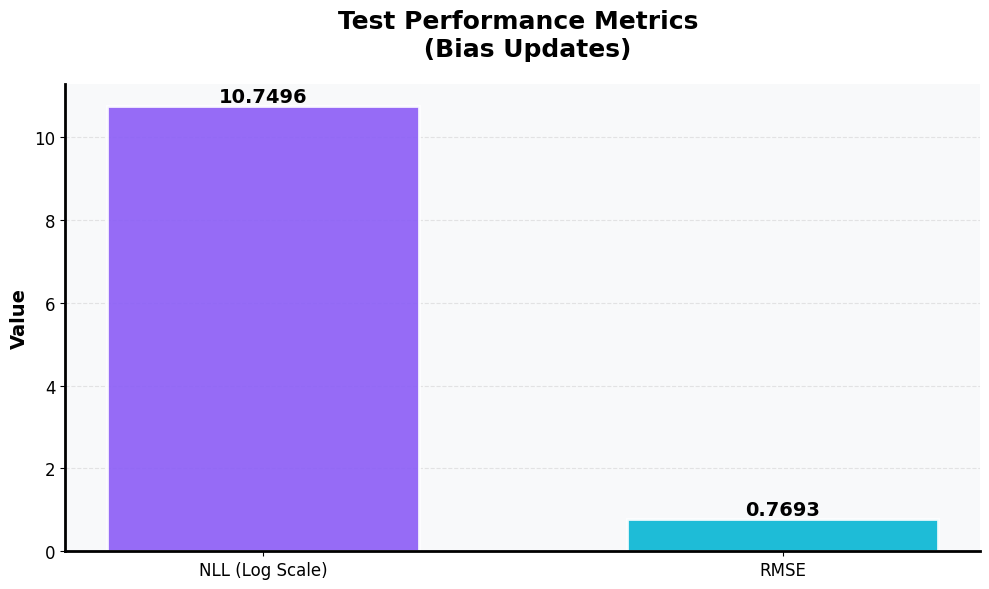

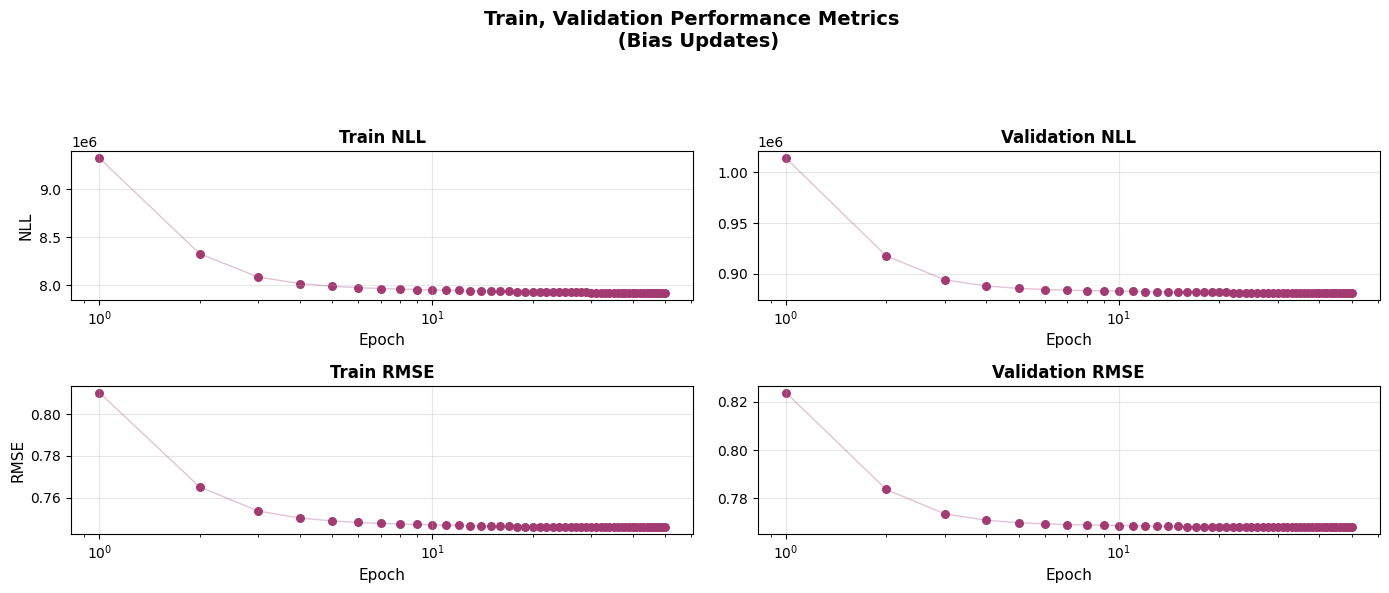

In [ ]:
dataset = MovieLensDataset_Optimized(DATASET_DIR, MOVIES_DIR)
history = dataset.train(
    test_size=0.1,
    latent_dim=latent_param.get_value(),
    n_iter=n_epochs_param.get_value(),
    eval_inter=eval_inter_param.get_value(),
    lambda_=lambda_param.get_value(),
    tau=1, gamma=tau_param.get_value(),
    eta=eta_param.get_value(),
    use_features=features_param.get_value(),
    biases_alone=only_biases_param.get_value(),
    verbose=True
)

test_loss, test_rmse = dataset.compute_loss(mode="test")
test_loss_param = Parameter(test_loss.item(), "test_NLL", "Performance")
test_rmse_param = Parameter(test_rmse.item(), "test_RMSE", "Performance")
experiment.add_params([
    test_loss_param,
    test_rmse_param
])

experiment.save()


dataset.test_performance(
    save_folder=save_folder,
    save_name="bias_updates_test_performance",
    title="Test Performance Metrics \n (Bias Updates)"
)
dataset.train_val_performance(
    **history,
    save_dir=f'{save_folder}',
    save_name='bias_updates_train+val_performance',
    title='Train, Validation Performance Metrics \n (Bias Updates)'
)

if features_param.get_value():
  np.savez(
      f"{save_folder}/model_(hyper)parameters_optimizedTrainer.npz",
      U=dataset.U, V=dataset.V,
      BM=dataset.BM, BN=dataset.BN,
      mu=dataset.mu, lambda_=dataset.lambda_,
      gamma=dataset.gamma, tau=dataset.tau,
      eta=dataset.eta,
      W=dataset.W
  )
else:
  np.savez(
      f"{save_folder}/model_(hyper)parameters_optimizedTrainer.npz",
      U=dataset.U, V=dataset.V,
      BM=dataset.BM, BN=dataset.BN,
      mu=dataset.mu, lambda_=dataset.lambda_,
      gamma=dataset.gamma, tau=dataset.tau,
      eta=dataset.eta
  )
np.savez(f"{save_folder}/optimizedTrainer_history.npz", **history)

In [ ]:
! zip -r AMLAS_Experiments.zip  experiments/

from google.colab import files
files.download('AMLAS_Experiments.zip')

  adding: experiments/ (stored 0%)
  adding: experiments/v1.1/ (stored 0%)
  adding: experiments/v1.1/pdfs/ (stored 0%)
  adding: experiments/v1.1/pdfs/bias_updates_test_performance.pdf (deflated 35%)
  adding: experiments/v1.1/pdfs/bias_updates_train+val_performance.pdf (deflated 34%)
  adding: experiments/v1.1/optimizedTrainer_history.npz (deflated 48%)
  adding: experiments/v1.1/model_(hyper)parameters_optimizedTrainer.npz (deflated 6%)
  adding: experiments/v1.1/v1.1.yaml (deflated 42%)
  adding: experiments/v1.1/pngs/ (stored 0%)
  adding: experiments/v1.1/pngs/bias_updates_test_performance.pngs (deflated 30%)
  adding: experiments/v1.1/pngs/bias_updates_train+val_performance.png (deflated 20%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Embedddings + Polarization

In [ ]:
# @title Use Saved Model

dataset = MovieLensDataset_Optimized(DATASET_DIR)
dataset.train_idx, dataset.val_idx, dataset.test_idx = dataset.train_test_split(split_ratio=0.9)

dataset.load_model('model_(hyper)parameters_optimizedTrainer.npz')
U = dataset.U
V = dataset.V
BM = dataset.BM
BN = dataset.BN
mu = dataset.mu

history = np.load('optimizedTrainer_history.npz', allow_pickle=False)

APPROACH 1: Embedding Magnitude (Norm)
Polarizing movies: 2959 (3.6%)
Threshold: 1.285, Mean: 0.349 ± 0.374
APPROACH 2: Embedding Direction (Niche vs Mainstream)
Niche/Polarizing movies: 32386 (39.0%)
Cluster sizes: [10330 14523  5911 10391  9953 10820 15026  6192]
APPROACH 3: Rating Variance (True Opinion Polarization)
Polarizing movies: 8315 (10.0%)
Variance threshold: 1.140, Mean: 0.525 ± 0.532


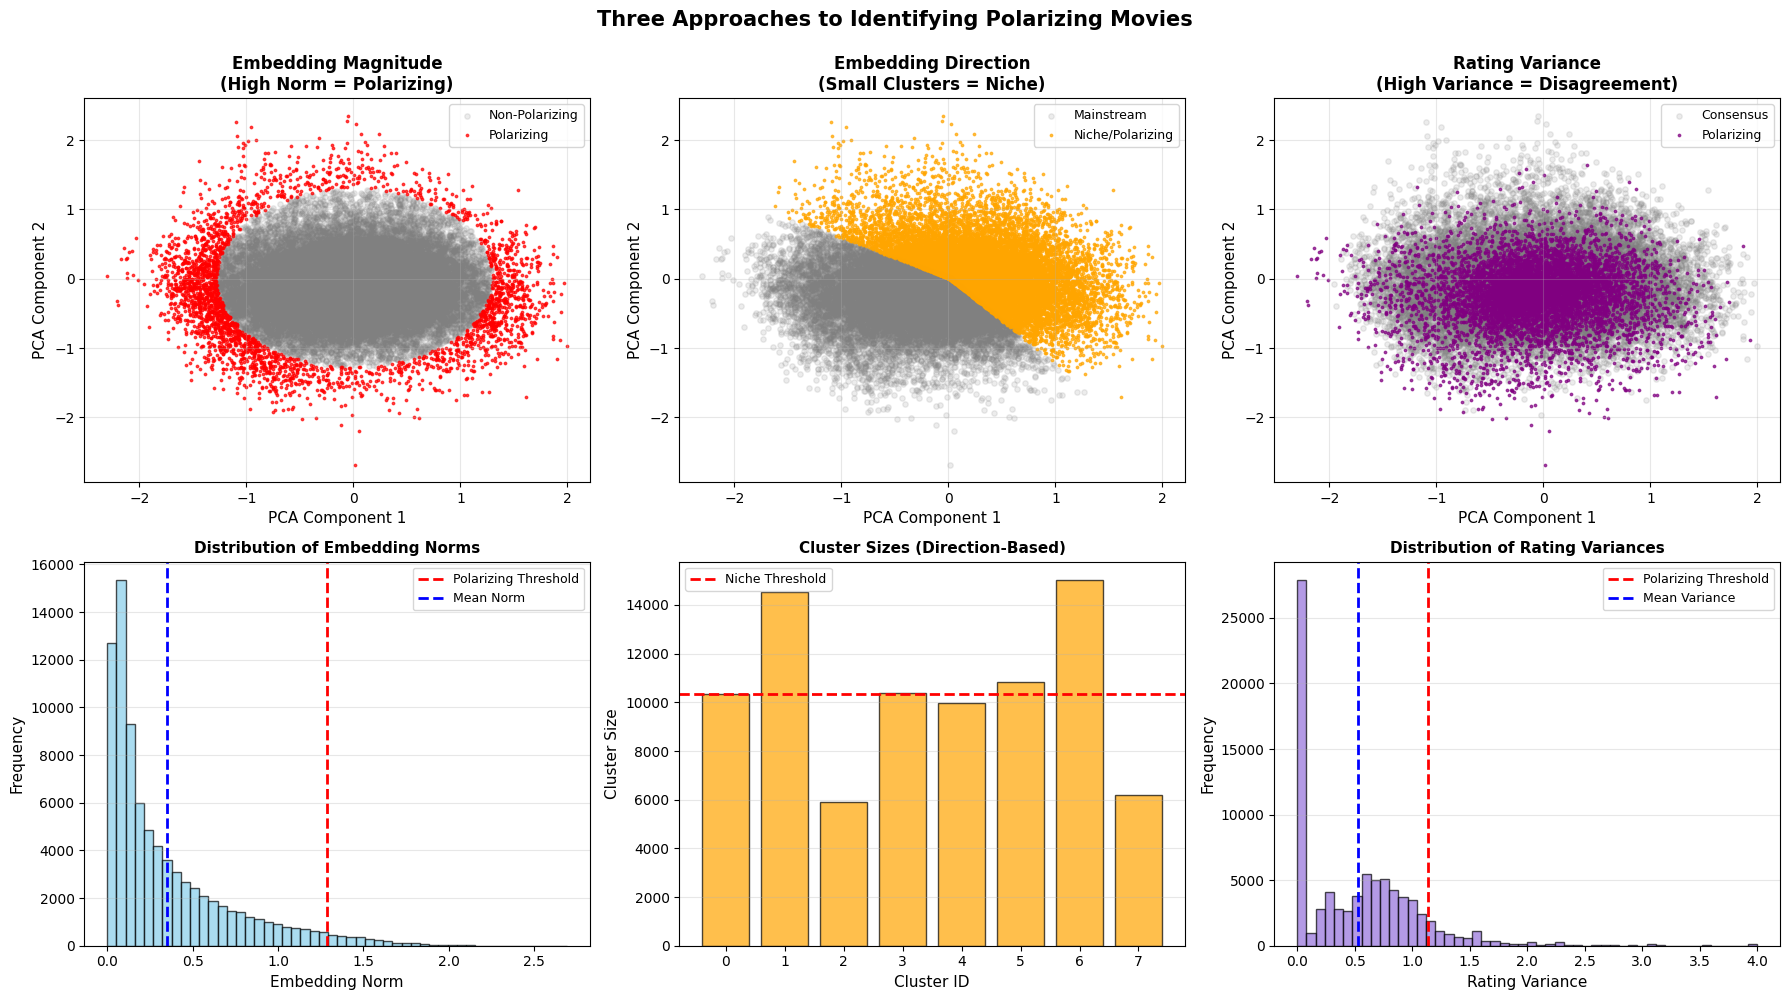

In [ ]:
# @title Finding Polarized Movies - Three Clustering Approaches
import gc
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

U = dataset.U
V = dataset.V

n_components_ = 2
embeddings_pca = PCA(n_components=n_components_)
embeddings_pca.fit(np.vstack((U, V)))

M, N = U.shape[0], V.shape[0]

# Transform all movie embeddings for visualization
movie_embedding = embeddings_pca.transform(V)

# =============================================================================
# APPROACH 1: Clustering by Embedding Magnitude (Norm)
# =============================================================================
movie_norms = np.array([np.linalg.norm(V[n, :]) for n in range(N)])
sigma_threshold = 2.5
threshold_high = np.mean(movie_norms) + sigma_threshold * np.std(movie_norms)
polarizing_norm_idx = np.where(movie_norms > threshold_high)[0]
non_polarizing_norm_idx = np.where(movie_norms <= threshold_high)[0]

print("=" * 60)
print("APPROACH 1: Embedding Magnitude (Norm)")
print(f"Polarizing movies: {len(polarizing_norm_idx)} ({100*len(polarizing_norm_idx)/N:.1f}%)")
print(f"Threshold: {threshold_high:.3f}, Mean: {movie_norms.mean():.3f} ± {movie_norms.std():.3f}")

# =============================================================================
# APPROACH 2: Clustering by Embedding Direction
# =============================================================================
V_normalized = V / np.linalg.norm(V, axis=1, keepdims=True)
n_direction_clusters = 8
kmeans_direction = KMeans(n_clusters=n_direction_clusters, random_state=42, n_init=10)
direction_clusters = kmeans_direction.fit_predict(V_normalized)

# Identify niche clusters (smaller clusters are more niche/polarizing)
cluster_sizes = np.array([np.sum(direction_clusters == i) for i in range(n_direction_clusters)])
niche_threshold = np.percentile(cluster_sizes, 50)
polarizing_direction_idx = []
non_polarizing_direction_idx = []
for n in range(N):
    cluster_id = direction_clusters[n]
    if cluster_sizes[cluster_id] < niche_threshold:
        polarizing_direction_idx.append(n)
    else:
        non_polarizing_direction_idx.append(n)

polarizing_direction_idx = np.array(polarizing_direction_idx)
non_polarizing_direction_idx = np.array(non_polarizing_direction_idx)

print("=" * 60)
print("APPROACH 2: Embedding Direction (Niche vs Mainstream)")
print(f"Niche/Polarizing movies: {len(polarizing_direction_idx)} ({100*len(polarizing_direction_idx)/N:.1f}%)")
print(f"Cluster sizes: {cluster_sizes}")

# =============================================================================
# APPROACH 3: Clustering by Rating Variance
# =============================================================================
train_users = dataset.users[dataset.train_idx]
train_movies = dataset.movies[dataset.train_idx]
train_ratings = dataset.ratings[dataset.train_idx]

# Build movie lookup if not already available
movie_to_indices_lookup = [[] for _ in range(N)]
for idx in range(len(train_movies)):
    movie_to_indices_lookup[train_movies[idx]].append(idx)

movie_variances = []
for n in range(N):
    indices = movie_to_indices_lookup[n]
    if len(indices) > 1:
        ratings_for_movie = train_ratings[indices]
        movie_variances.append(np.var(ratings_for_movie))
    else:
        movie_variances.append(0)

movie_variances = np.array(movie_variances)
variance_threshold = np.percentile(movie_variances, 90)
polarizing_variance_idx = np.where(movie_variances > variance_threshold)[0]
non_polarizing_variance_idx = np.where(movie_variances <= variance_threshold)[0]

print("=" * 60)
print("APPROACH 3: Rating Variance (True Opinion Polarization)")
print(f"Polarizing movies: {len(polarizing_variance_idx)} ({100*len(polarizing_variance_idx)/N:.1f}%)")
print(f"Variance threshold: {variance_threshold:.3f}, Mean: {movie_variances.mean():.3f} ± {movie_variances.std():.3f}")
print("=" * 60)

# =============================================================================
# VISUALIZATION: Two Rows (Scatter Plots + Histograms)
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# ----------------------- ROW 1: SCATTER PLOTS -----------------------

# Subplot 1: Embedding Magnitude
ax = axes[0, 0]
xy = movie_embedding[non_polarizing_norm_idx]
ax.scatter(xy[:, 0], xy[:, 1], alpha=0.15, s=15, color='gray', label='Non-Polarizing')
xy = movie_embedding[polarizing_norm_idx]
ax.scatter(xy[:, 0], xy[:, 1], s=3, color='red', label='Polarizing', alpha=0.7)
ax.set_xlabel('PCA Component 1', fontsize=11)
ax.set_ylabel('PCA Component 2', fontsize=11)
ax.set_title('Embedding Magnitude\n(High Norm = Polarizing)', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)

# Subplot 2: Embedding Direction
ax = axes[0, 1]
xy = movie_embedding[non_polarizing_direction_idx]
ax.scatter(xy[:, 0], xy[:, 1], alpha=0.15, s=15, color='gray', label='Mainstream')
xy = movie_embedding[polarizing_direction_idx]
ax.scatter(xy[:, 0], xy[:, 1], s=3, color='orange', label='Niche/Polarizing', alpha=0.7)
ax.set_xlabel('PCA Component 1', fontsize=11)
ax.set_ylabel('PCA Component 2', fontsize=11)
ax.set_title('Embedding Direction\n(Small Clusters = Niche)', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)

# Subplot 3: Rating Variance
ax = axes[0, 2]
xy = movie_embedding[non_polarizing_variance_idx]
ax.scatter(xy[:, 0], xy[:, 1], alpha=0.15, s=15, color='gray', label='Consensus')
xy = movie_embedding[polarizing_variance_idx]
ax.scatter(xy[:, 0], xy[:, 1], s=3, color='purple', label='Polarizing', alpha=0.7)
ax.set_xlabel('PCA Component 1', fontsize=11)
ax.set_ylabel('PCA Component 2', fontsize=11)
ax.set_title('Rating Variance\n(High Variance = Disagreement)', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)

# ----------------------- ROW 2: HISTOGRAMS -----------------------

# Histogram 1: Embedding Magnitude (Norms)
ax = axes[1, 0]
ax.hist(movie_norms, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
ax.axvline(threshold_high, color='red', linestyle='--', linewidth=2, label='Polarizing Threshold')
ax.axvline(movie_norms.mean(), color='blue', linestyle='--', linewidth=2, label='Mean Norm')
ax.set_xlabel('Embedding Norm', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Distribution of Embedding Norms', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3, axis='y')

# Histogram 2: Cluster Sizes
ax = axes[1, 1]
ax.bar(range(n_direction_clusters), cluster_sizes, alpha=0.7, edgecolor='black', color='orange')
ax.axhline(niche_threshold, color='red', linestyle='--', linewidth=2, label='Niche Threshold')
ax.set_xlabel('Cluster ID', fontsize=11)
ax.set_ylabel('Cluster Size', fontsize=11)
ax.set_title('Cluster Sizes (Direction-Based)', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3, axis='y')

# Histogram 3: Rating Variance
ax = axes[1, 2]
ax.hist(movie_variances, bins=50, alpha=0.7, edgecolor='black', color='mediumpurple')
ax.axvline(variance_threshold, color='red', linestyle='--', linewidth=2, label='Polarizing Threshold')
ax.axvline(movie_variances.mean(), color='blue', linestyle='--', linewidth=2, label='Mean Variance')
ax.set_xlabel('Rating Variance', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Distribution of Rating Variances', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3, axis='y')

fig.suptitle('Three Approaches to Identifying Polarizing Movies', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()

fig.savefig(
    f'{save_folder}/pngs/polarization_three_methods.png',
    format='png',
    dpi=300,
    bbox_inches='tight'
)
fig.savefig(
    f'{save_folder}/pdfs/polarization_three_methods.pdf',
    format='pdf',
    dpi=300,
    bbox_inches='tight'
)

plt.show()

Total movies: 83,146
Polarizing by norm: 2959 (3.6%)
Polarizing by variance: 8315 (10.0%)
Polarizing by BOTH: 665 (0.8%)


  0%|          | 87585/32000204 [00:00<01:02, 507514.97it/s]



TOP 20 MOST POLARIZING MOVIES (by both norm and variance):
--------------------------------------------------------------------------------
Rank  Movie ID    Norm      Variance    Avg Rating  # Ratings   
--------------------------------------------------------------------------------
1     150724      1.659     3.188       2.75        4           
2     1311        1.811     2.741       2.63        139         
3     1383        2.020     2.257       2.54        118         
4     128169      2.130     2.059       2.81        26          
5     74754       2.103     2.068       3.05        820         
6     4255        2.692     1.524       2.53        1571        
7     1787        1.595     2.569       3.47        18          
8     159423      1.510     2.602       3.43        7           
9     137583      2.028     1.931       3.33        12          
10    146112      1.408     2.688       3.75        4           
11    110603      2.121     1.782       3.06        160        

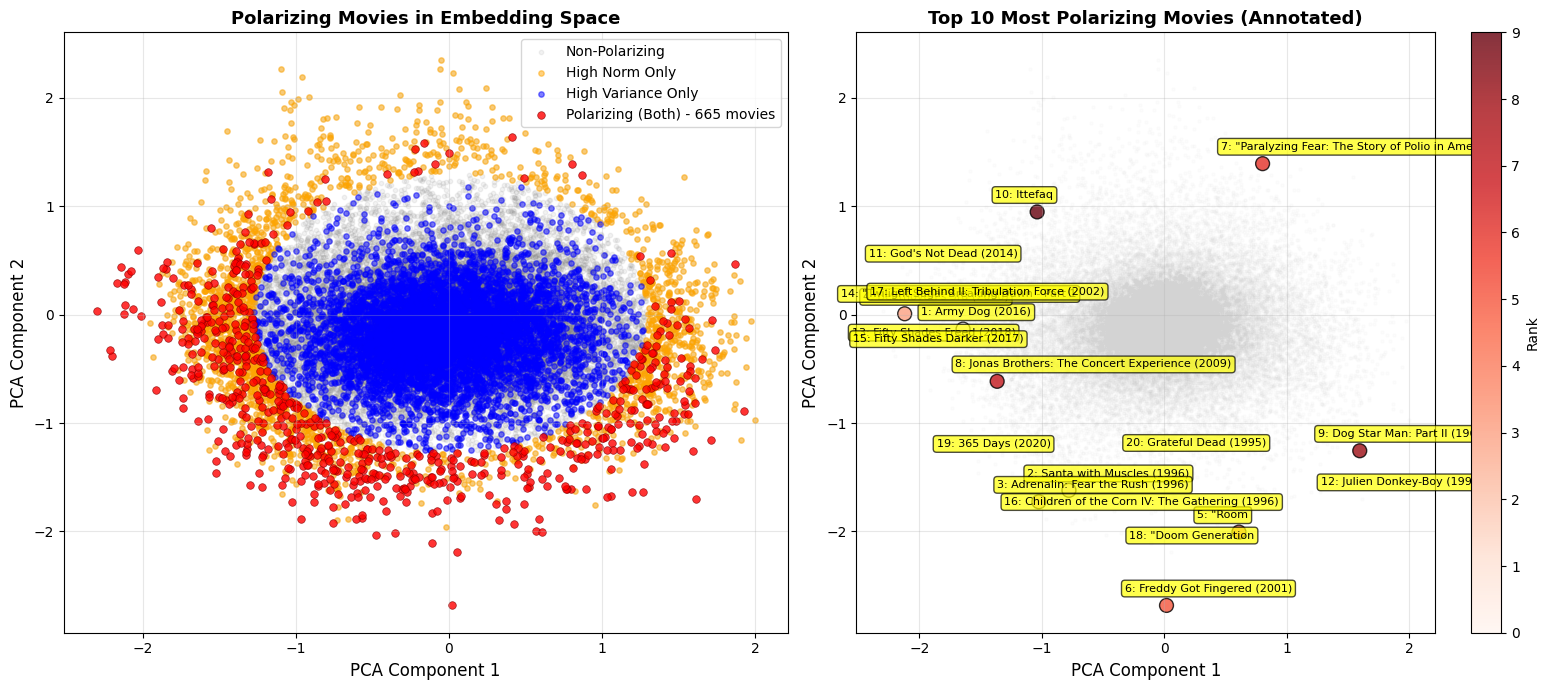

In [ ]:
# @title Visualize Polarizing Movies with Movie Titles
import gc
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have trained the model and have U, V available
# If using the dataset's train method:
# dataset = MovieLensDataset_Optimized(DATASET_DIR)
# history = dataset.train(test_size=0.1, latent_dim=10, n_iter=50)
# U, V = dataset.U, dataset.V

n_components_ = 2
embeddings_pca = PCA(n_components=n_components_)
embeddings_pca.fit(np.vstack((U, V)))

M, N = U.shape[0], V.shape[0]

# Transform all movie embeddings for visualization
movie_embedding = embeddings_pca.transform(V)

# =============================================================================
# Calculate Polarization Metrics
# =============================================================================

# 1. Embedding Magnitude (Norm)
movie_norms = np.array([np.linalg.norm(V[n, :]) for n in range(N)])
sigma_threshold = 2.5
threshold_high = np.mean(movie_norms) + sigma_threshold * np.std(movie_norms)
polarizing_norm_idx = np.where(movie_norms > threshold_high)[0]

# 2. Rating Variance
train_users = dataset.users[dataset.train_idx]
train_movies = dataset.movies[dataset.train_idx]
train_ratings = dataset.ratings[dataset.train_idx]

movie_to_indices_lookup = [[] for _ in range(N)]
for idx in range(len(train_movies)):
    movie_to_indices_lookup[train_movies[idx]].append(idx)

movie_variances = []
movie_avg_ratings = []
movie_rating_counts = []
for n in range(N):
    indices = movie_to_indices_lookup[n]
    if len(indices) > 1:
        ratings_for_movie = train_ratings[indices]
        movie_variances.append(np.var(ratings_for_movie))
        movie_avg_ratings.append(np.mean(ratings_for_movie))
        movie_rating_counts.append(len(ratings_for_movie))
    else:
        movie_variances.append(0)
        movie_avg_ratings.append(0)
        movie_rating_counts.append(0)

movie_variances = np.array(movie_variances)
movie_avg_ratings = np.array(movie_avg_ratings)
movie_rating_counts = np.array(movie_rating_counts)

variance_threshold = np.percentile(movie_variances, 90)
polarizing_variance_idx = np.where(movie_variances > variance_threshold)[0]

# Find movies that are polarizing by BOTH metrics
polarizing_both = np.intersect1d(polarizing_norm_idx, polarizing_variance_idx)

print("=" * 80)
print(f"Total movies: {N:,}")
print(f"Polarizing by norm: {len(polarizing_norm_idx)} ({100*len(polarizing_norm_idx)/N:.1f}%)")
print(f"Polarizing by variance: {len(polarizing_variance_idx)} ({100*len(polarizing_variance_idx)/N:.1f}%)")
print(f"Polarizing by BOTH: {len(polarizing_both)} ({100*len(polarizing_both)/N:.1f}%)")
print("=" * 80)

# =============================================================================
# Get Top Polarizing Movies with Details
# =============================================================================
with open(MOVIES_DIR, "r", encoding="utf-8") as file:
  next(file)
  movies_info = dict()

  for line in tqdm(file, total=32000204):
    line = line.strip(" ")
    values = line.split(",")
    # print(values)
    movie = int(values[0])
    movie_title = values[1]
    genre = values[2]

    movies_info[movie] = {
      'title': movie_title,
      'genre': genre
    }

def get_movie_details(movie_idx_list, top_n=20, movies_map=movies_info):
    """Get details for top polarizing movies"""
    details = []
    for idx in movie_idx_list:
      original_movie_id = dataset.movies_reverse_map[idx]
      details.append({
        'idx': idx,
        'original_id': original_movie_id,
        'title': movies_info[original_movie_id]['title'],
        'genre': movies_info[original_movie_id]['genre'],
        'norm': movie_norms[idx],
        'variance': movie_variances[idx],
        'avg_rating': movie_avg_ratings[idx],
        'num_ratings': movie_rating_counts[idx]
      })

    # Sort by combined score (norm + variance)
    details_sorted = sorted(details,
                           key=lambda x: x['norm'] * x['variance'],
                           reverse=True)
    return details_sorted[:top_n]

# Get top polarizing movies
top_polarizing = get_movie_details(polarizing_both, top_n=20)

print("\nTOP 20 MOST POLARIZING MOVIES (by both norm and variance):")
print("-" * 80)
print(f"{'Rank':<6}{'Movie ID':<12}{'Norm':<10}{'Variance':<12}{'Avg Rating':<12}{'# Ratings':<12}")
print("-" * 80)
for i, movie in enumerate(top_polarizing, 1):
    print(f"{i:<6}{movie['original_id']:<12}{movie['norm']:<10.3f}{movie['variance']:<12.3f}"
          f"{movie['avg_rating']:<12.2f}{movie['num_ratings']:<12}")

# =============================================================================
# VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: All polarizing movies
ax = axes[0]
# Non-polarizing
non_polarizing = np.setdiff1d(np.arange(N), polarizing_both)
xy = movie_embedding[non_polarizing]
ax.scatter(xy[:, 0], xy[:, 1], alpha=0.1, s=10, color='gray', label='Non-Polarizing')

# Polarizing by norm only
norm_only = np.setdiff1d(polarizing_norm_idx, polarizing_both)
xy = movie_embedding[norm_only]
ax.scatter(xy[:, 0], xy[:, 1], s=15, color='orange', alpha=0.5, label='High Norm Only')

# Polarizing by variance only
variance_only = np.setdiff1d(polarizing_variance_idx, polarizing_both)
xy = movie_embedding[variance_only]
ax.scatter(xy[:, 0], xy[:, 1], s=15, color='blue', alpha=0.5, label='High Variance Only')

# Polarizing by BOTH
xy = movie_embedding[polarizing_both]
ax.scatter(xy[:, 0], xy[:, 1], s=30, color='red', alpha=0.8,
          label=f'Polarizing (Both) - {len(polarizing_both)} movies', edgecolor='darkred', linewidth=0.5)

ax.set_xlabel('PCA Component 1', fontsize=12)
ax.set_ylabel('PCA Component 2', fontsize=12)
ax.set_title('Polarizing Movies in Embedding Space', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)

# Plot 2: Annotate top polarizing movies
ax = axes[1]
# All movies in background
xy = movie_embedding
ax.scatter(xy[:, 0], xy[:, 1], alpha=0.05, s=5, color='lightgray')

# Top polarizing movies
top_indices = [m['idx'] for m in top_polarizing[:10]]  # Top 10 for readability
xy = movie_embedding[top_indices]
scatter = ax.scatter(xy[:, 0], xy[:, 1], s=100, c=range(len(top_indices)),
                     cmap='Reds', alpha=0.8, edgecolor='black', linewidth=1)

# Annotate with movie IDs
for i, movie in enumerate(top_polarizing):
    idx = movie['idx']
    ax.annotate(f"{i+1}: {movie['title']}",
      xy=movie_embedding[idx],
      xytext=(-30, 10),
      textcoords='offset points',
      fontsize=8,
      bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_xlabel('PCA Component 1', fontsize=12)
ax.set_ylabel('PCA Component 2', fontsize=12)
ax.set_title('Top 10 Most Polarizing Movies (Annotated)', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

plt.colorbar(scatter, ax=ax, label='Rank')
plt.tight_layout()
fig.savefig(
    f'{save_folder}/pngs/polarization+movie_names.png',
    format='png',
    dpi=300,
    bbox_inches='tight'
)
fig.savefig(
    f'{save_folder}/pdfs/polarization+movie_names.pdf',
    format='pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

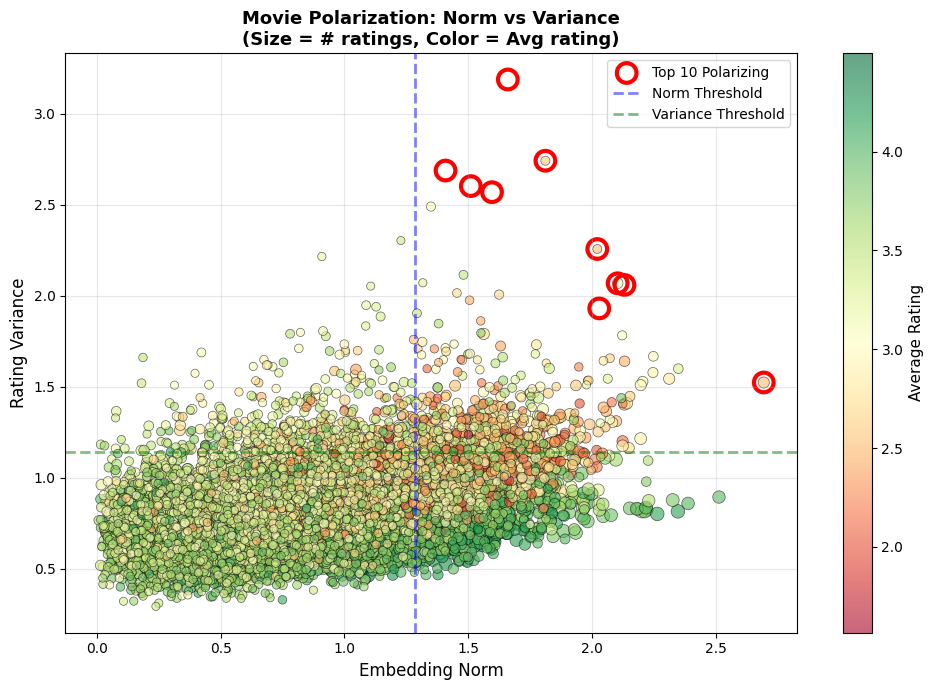

In [ ]:
# @title Polariztion, Embedding Norms, Rating Variances

# =============================================================================
# Additional Analysis: Scatter plot of Norm vs Variance
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 7))

# Filter movies with sufficient ratings (e.g., >50 ratings)
min_ratings = 50
valid_idx = movie_rating_counts > min_ratings

# Scatter plot
scatter = ax.scatter(movie_norms[valid_idx],
                    movie_variances[valid_idx],
                    c=movie_avg_ratings[valid_idx],
                    s=np.log10(movie_rating_counts[valid_idx] + 1) * 20,
                    alpha=0.6,
                    cmap='RdYlGn',
                    edgecolor='black',
                    linewidth=0.5)

# Highlight top polarizing
top_indices = [m['idx'] for m in top_polarizing[:10]]
ax.scatter(movie_norms[top_indices],
          movie_variances[top_indices],
          s=200,
          facecolors='none',
          edgecolors='red',
          linewidth=3,
          label='Top 10 Polarizing')

# Threshold lines
ax.axvline(threshold_high, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Norm Threshold')
ax.axhline(variance_threshold, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Variance Threshold')

ax.set_xlabel('Embedding Norm', fontsize=12)
ax.set_ylabel('Rating Variance', fontsize=12)
ax.set_title('Movie Polarization: Norm vs Variance\n(Size = # ratings, Color = Avg rating)',
            fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Average Rating', fontsize=11)

plt.tight_layout()
fig.savefig(
    f'{save_folder}/pngs/polarization_embedding_norms+rating_variances.png',
    format='png',
    dpi=300,
    bbox_inches='tight'
)
fig.savefig(
    f'{save_folder}/pdfs/polarization_embedding_norms+rating_variances.pdf',
    format='pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

#### Dummy user recommendation

In [ ]:
# @title Dummy User Movie Recommendation with Top 10 Annotated (Filtered by Min Ratings)

mu = dataset.mu
BM = dataset.BM
BN = dataset.BN
M, N = dataset.user_movie_counts()

with open(MOVIES_DIR, "r", encoding="utf-8") as file:
  next(file)
  movies_info = dict()

  for line in tqdm(file, total=N):
    line = line.strip(" ")
    values = line.split(",")
    movie = int(values[0])
    movie_title = values[1]
    genre = values[2]

    movies_info[movie] = {
      'title': movie_title,
      'genre': genre
    }

# Filter movies with at least 100 ratings
min_ratings_threshold = 100

# Count ratings per movie
movie_rating_counts = np.bincount(dataset.movies, minlength=N)

# Generate dummy user
random_movie_idx = dataset.users_map[7993]
movie_mask = dataset.movies == random_movie_idx
movie_users = dataset.users[movie_mask]
movie_ratings = dataset.ratings[movie_mask]

# Create movie trait vector more efficiently
movie_trait = np.zeros(M)
movie_trait[movie_users] = movie_ratings

# Generate dummy user embedding
dummy_user_embedding = dataset.U.T @ movie_trait

# Generate Movie Predictions
scores = mu + (V @ dummy_user_embedding) + BN

mask = movie_rating_counts < min_ratings_threshold
scores[mask] = -np.inf

best_movies_match = np.argsort(scores)[::-1][0:1000]
top_10_matches = best_movies_match[:10]


# Print top 10 recommendations
print("\n" + "=" * 80)
print(f"TOP 10 RECOMMENDED MOVIES (with >={min_ratings_threshold} ratings):")
print("-" * 80)
print(f"{'Rank':<6}{'Movie ID':<12}{'Title':<40}{'Similarity':<12}{'# Ratings':<12}")
print("-" * 80)
for i, movie_idx in enumerate(top_10_matches, 1):
    original_movie_id = dataset.movies_reverse_map[movie_idx]
    title = movies_info.get(original_movie_id, {}).get('title', 'Unknown')
    print(f"{i:<6}{original_movie_id:<12}{title:<40}")
print("=" * 80)

# Also show the seed movie
seed_movie_id = dataset.movies_reverse_map[random_movie_idx]
seed_title = movies_info.get(seed_movie_id, {}).get('title', 'Unknown')
seed_rating_count = movie_rating_counts[random_movie_idx]
# print(f"\nSeed Movie (Rated {rating} stars): {seed_title} (ID: {seed_movie_id})")
print(f"\nSeed Movie: {seed_title} (ID: {seed_movie_id})")
print(f"Seed movie has {seed_rating_count} ratings")

87585it [00:00, 532351.37it/s]                           



TOP 10 RECOMMENDED MOVIES (with >=100 ratings):
--------------------------------------------------------------------------------
Rank  Movie ID    Title                                   Similarity  # Ratings   
--------------------------------------------------------------------------------
1     2382        Police Academy 5: Assignment: Miami Beach (1988)
2     168712      Fifty Shades Darker (2017)              
3     216167      365 Days (2020)                         
4     183589      Fifty Shades Freed (2018)               
5     8387        Police Academy: Mission to Moscow (1994)
6     125916      Fifty Shades of Grey (2015)             
7     101997      Scary Movie 5 (Scary MoVie) (2013)      
8     34530       Deuce Bigalow: European Gigolo (2005)   
9     81535       Saw VII 3D - The Final Chapter (2010)   
10    2381        Police Academy 4: Citizens on Patrol (1987)

Seed Movie: "Good Old Fashioned Orgy (ID: 97232)
Seed movie has 146 ratings


87585it [00:00, 558737.41it/s]                           


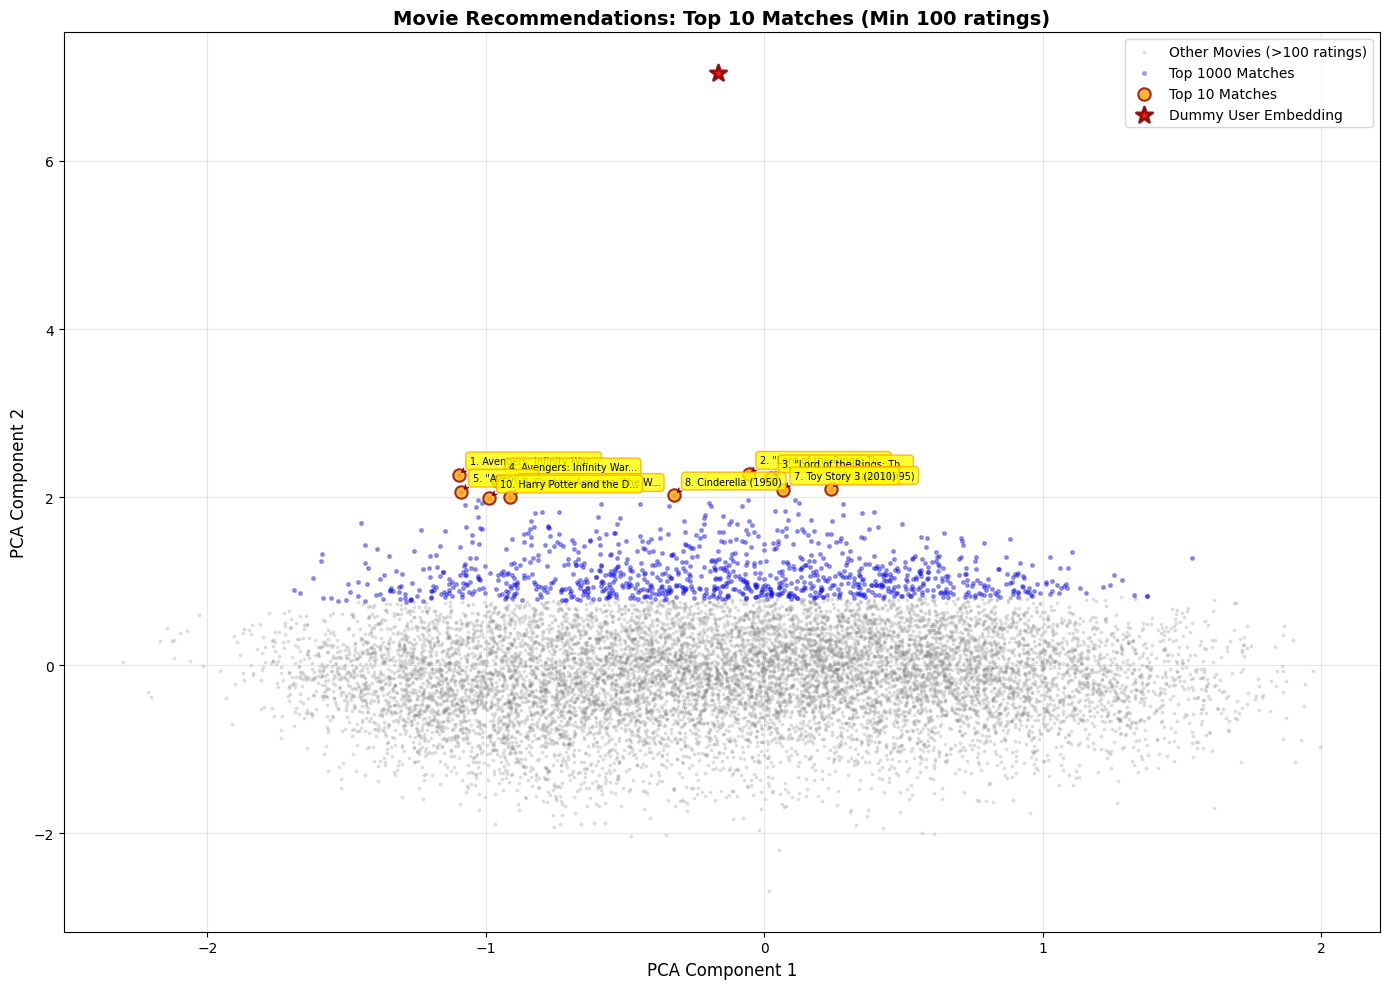


TOP 10 RECOMMENDED MOVIES (with >=100 ratings):
--------------------------------------------------------------------------------
Rank  Movie ID    Title                                   Score       # Ratings   
--------------------------------------------------------------------------------
1     122914      Avengers: Infinity War - Part II (2019) 16.0577     11506       
2     5952        "Lord of the Rings: The Two Towers      15.9276     66396       
3     4993        "Lord of the Rings: The Fellowship of the Ring15.6078     71965       
4     122912      Avengers: Infinity War - Part I (2018)  15.5283     14274       
5     89745       "Avengers                               14.6151     25709       
6     34          Babe (1995)                             14.6104     35409       
7     78499       Toy Story 3 (2010)                      14.5950     19960       
8     1022        Cinderella (1950)                       14.2348     11096       
9     110102      Captain America: T

In [ ]:
# @title Dummy User Movie Recommendation with Top 10 Annotated (Filtered by Min Ratings)
import matplotlib.pyplot as plt

M, N = dataset.user_movie_counts()

with open(MOVIES_DIR, "r", encoding="utf-8") as file:
  next(file)
  movies_info = dict()

  for line in tqdm(file, total=N):
    line = line.strip(" ")
    values = line.split(",")
    movie = int(values[0])
    movie_title = values[1]
    genre = values[2]

    movies_info[movie] = {
      'title': movie_title,
      'genre': genre
    }

# Filter movies with at least 100 ratings
min_ratings_threshold = 100

# Count ratings per movie
movie_rating_counts = np.bincount(dataset.movies, minlength=N)

# Generate dummy user based on a seed movie
movie_id = 7153 # @param
rating = 3 # @param
random_movie_idx = dataset.movies_map[movie_id]
# dummy_user_embedding = V[random_movie_idx]
user_trait = np.zeros(N)
user_trait[random_movie_idx] = rating
dummy_user_embedding = V.T @ user_trait

# Correct scoring with all components
# scores = (V @ dummy_user_embedding) / (np.linalg.norm(V, axis=1) * np.linalg.norm(dummy_user_embedding))
scores = (V @ dummy_user_embedding) + 0.01*BN

# Mask out movies with too few ratings
mask = movie_rating_counts < min_ratings_threshold
scores[mask] = -np.inf

# Also exclude the seed movie itself from recommendations
scores[random_movie_idx] = -np.inf

best_movies_match = np.argsort(scores)[::-1]
top_10_matches = best_movies_match[:10]

valid_movie_indices = np.where(movie_rating_counts >= min_ratings_threshold)[0]
best_match_embeddings = V[best_movies_match[:1000], :]

# Create plot
fig, ax = plt.subplots(figsize=(14, 10))

# All other movies (gray) - only valid movies
other_movies = [i for i in valid_movie_indices if i not in top_10_matches]
xy = embeddings_pca.transform(V[other_movies, :])
ax.scatter(xy[:, 0], xy[:, 1], color='gray', alpha=0.2, s=3, label='Other Movies (>100 ratings)')

# Best 1000 matches (blue)
xy = embeddings_pca.transform(best_match_embeddings)
ax.scatter(xy[:, 0], xy[:, 1], color='blue', alpha=0.3, s=7, label='Top 1000 Matches')

# Top 10 matches (larger, highlighted)
xy_top10 = embeddings_pca.transform(V[top_10_matches, :])
ax.scatter(xy_top10[:, 0], xy_top10[:, 1], color='orange', alpha=0.8, s=80,
          edgecolor='darkred', linewidth=1.5, zorder=5, label='Top 10 Matches')

# Annotate top 10 with movie titles
for i, movie_idx in enumerate(top_10_matches):
    original_movie_id = dataset.movies_reverse_map[movie_idx]

    # Get movie title
    if original_movie_id in movies_info:
        title = movies_info[original_movie_id]['title']
        # Truncate long titles
        if len(title) > 25:
            title = title[:22] + "..."
    else:
        title = f"Movie {original_movie_id}"

    # Annotate
    ax.annotate(f"{i+1}. {title}",
               xy=xy_top10[i],
               xytext=(8, 8),
               textcoords='offset points',
               fontsize=7,
               bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.8, edgecolor='orange'),
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',
                             color='darkred', lw=1),
               zorder=6)

# Dummy embedding (red)
xy = embeddings_pca.transform(dummy_user_embedding[np.newaxis, :])
ax.scatter(xy[:, 0], xy[:, 1], color='red', alpha=0.9, s=150,
          marker='*', edgecolor='darkred', linewidth=2, zorder=7, label='Dummy User Embedding')

ax.set_xlabel('PCA Component 1', fontsize=12)
ax.set_ylabel('PCA Component 2', fontsize=12)
ax.set_title(f'Movie Recommendations: Top 10 Matches (Min {min_ratings_threshold} ratings)',
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
fig.savefig(
    f'{save_folder}/pngs/dummy_user_recommendations_LOR.png',
    format='png',
    dpi=300,
    bbox_inches='tight'
)
fig.savefig(
    f'{save_folder}/pdfs/dummy_user_recommendations_LOR.pdf',
    format='pdf',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

# Print top 10 recommendations
print("\n" + "=" * 80)
print(f"TOP 10 RECOMMENDED MOVIES (with >={min_ratings_threshold} ratings):")
print("-" * 80)
print(f"{'Rank':<6}{'Movie ID':<12}{'Title':<40}{'Score':<12}{'# Ratings':<12}")
print("-" * 80)
for i, movie_idx in enumerate(top_10_matches, 1):
    original_movie_id = dataset.movies_reverse_map[movie_idx]
    title = movies_info.get(original_movie_id, {}).get('title', 'Unknown')
    score = scores[movie_idx]
    rating_count = movie_rating_counts[movie_idx]
    print(f"{i:<6}{original_movie_id:<12}{title:<40}{score:<12.4f}{rating_count:<12}")
print("=" * 80)

# Show the seed movie
seed_movie_id = dataset.movies_reverse_map[random_movie_idx]
seed_title = movies_info.get(seed_movie_id, {}).get('title', 'Unknown')
seed_rating_count = movie_rating_counts[random_movie_idx]
print(f"\nSeed Movie: {seed_title} (ID: {seed_movie_id})")
print(f"Seed movie has {seed_rating_count} ratings")
# print(f"Dummy user rated this movie: {actual_rating:.1f} stars")

In [ ]:
! zip -r AMLAS_Experiments.zip  experiments/

from google.colab import files
files.download('AMLAS_Experiments.zip')

updating: experiments/ (stored 0%)
updating: experiments/v1.1/ (stored 0%)
updating: experiments/v1.1/pdfs/ (stored 0%)
updating: experiments/v1.1/pdfs/bias_updates_test_performance.pdf (deflated 35%)
updating: experiments/v1.1/pdfs/bias_updates_train+val_performance.pdf (deflated 34%)
updating: experiments/v1.1/optimizedTrainer_history.npz (deflated 48%)
updating: experiments/v1.1/model_(hyper)parameters_optimizedTrainer.npz (deflated 6%)
updating: experiments/v1.1/v1.1.yaml (deflated 42%)
updating: experiments/v1.1/pngs/ (stored 0%)
updating: experiments/v1.1/pngs/bias_updates_test_performance.pngs (deflated 30%)
updating: experiments/v1.1/pngs/bias_updates_train+val_performance.png (deflated 20%)
  adding: experiments/v1.1/pdfs/polarization+movie_names.pdf (deflated 1%)
  adding: experiments/v1.1/pdfs/dummy_user_recommendations_LOR.pdf (deflated 4%)
  adding: experiments/v1.1/pdfs/polarization_embedding_norms+rating_variances.pdf (deflated 2%)
  adding: experiments/v1.1/pdfs/polariz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Feature Plots

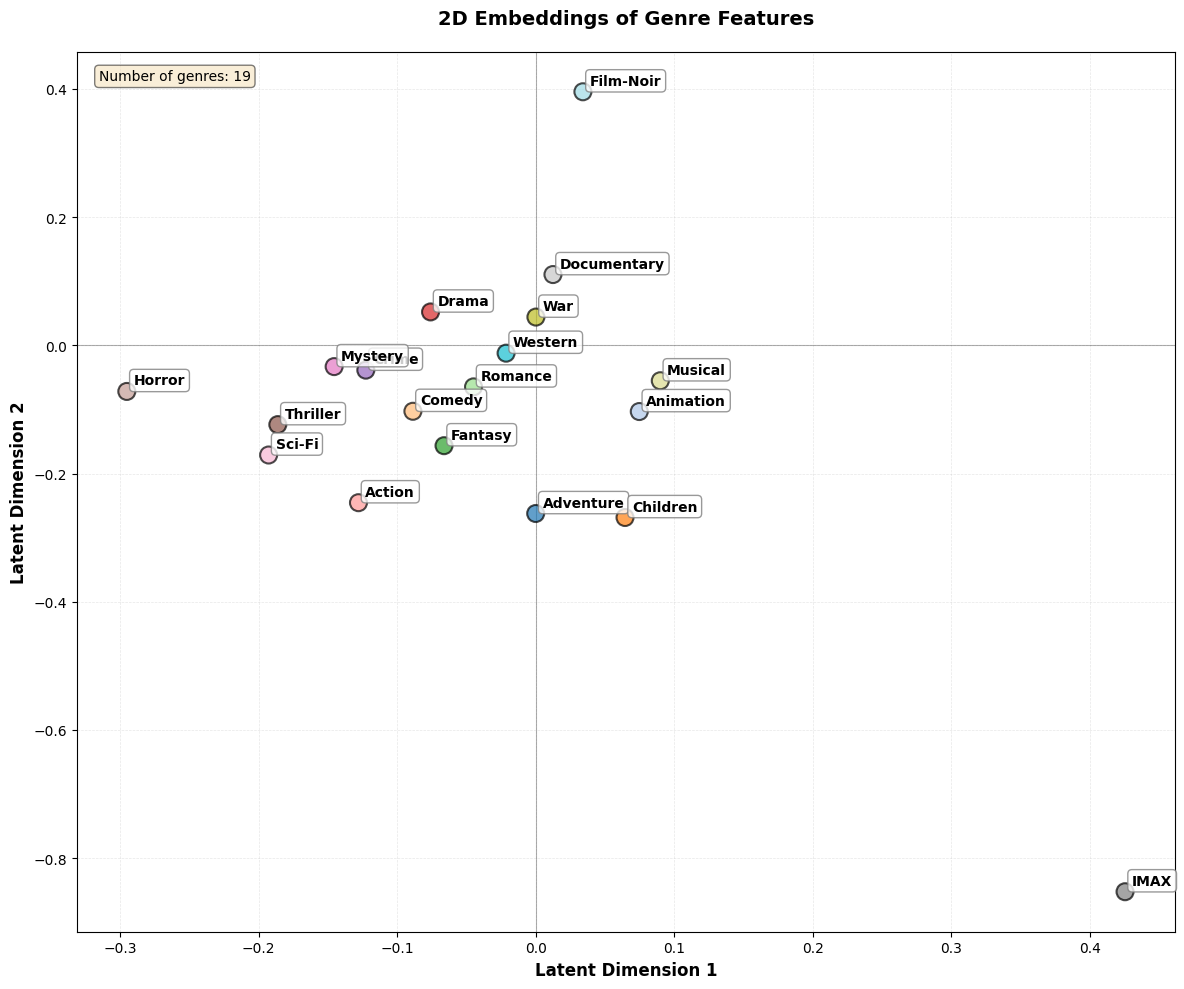

(<Figure size 1200x1000 with 1 Axes>,
 <Axes: title={'center': '2D Embeddings of Genre Features'}, xlabel='Latent Dimension 1', ylabel='Latent Dimension 2'>)

In [ ]:
dataset.plot_feature_embeddings(
    save_dir=f"{save_folder}",
    save_name="features_embeddings"
)

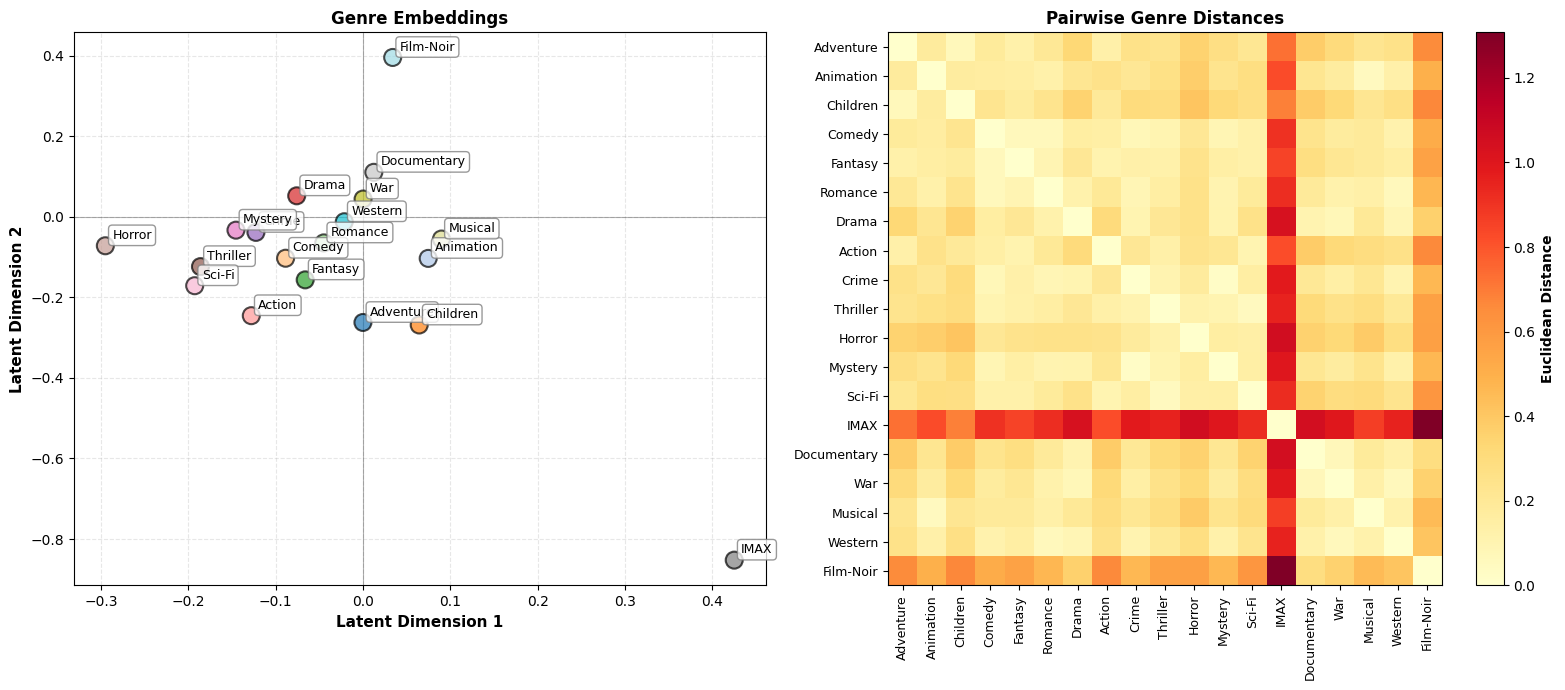

In [ ]:
_ = dataset.plot_feature_embeddings_with_clustering(
    save_dir=f"{save_folder}",
    save_name="features_embedding_clustering_analysis"
)

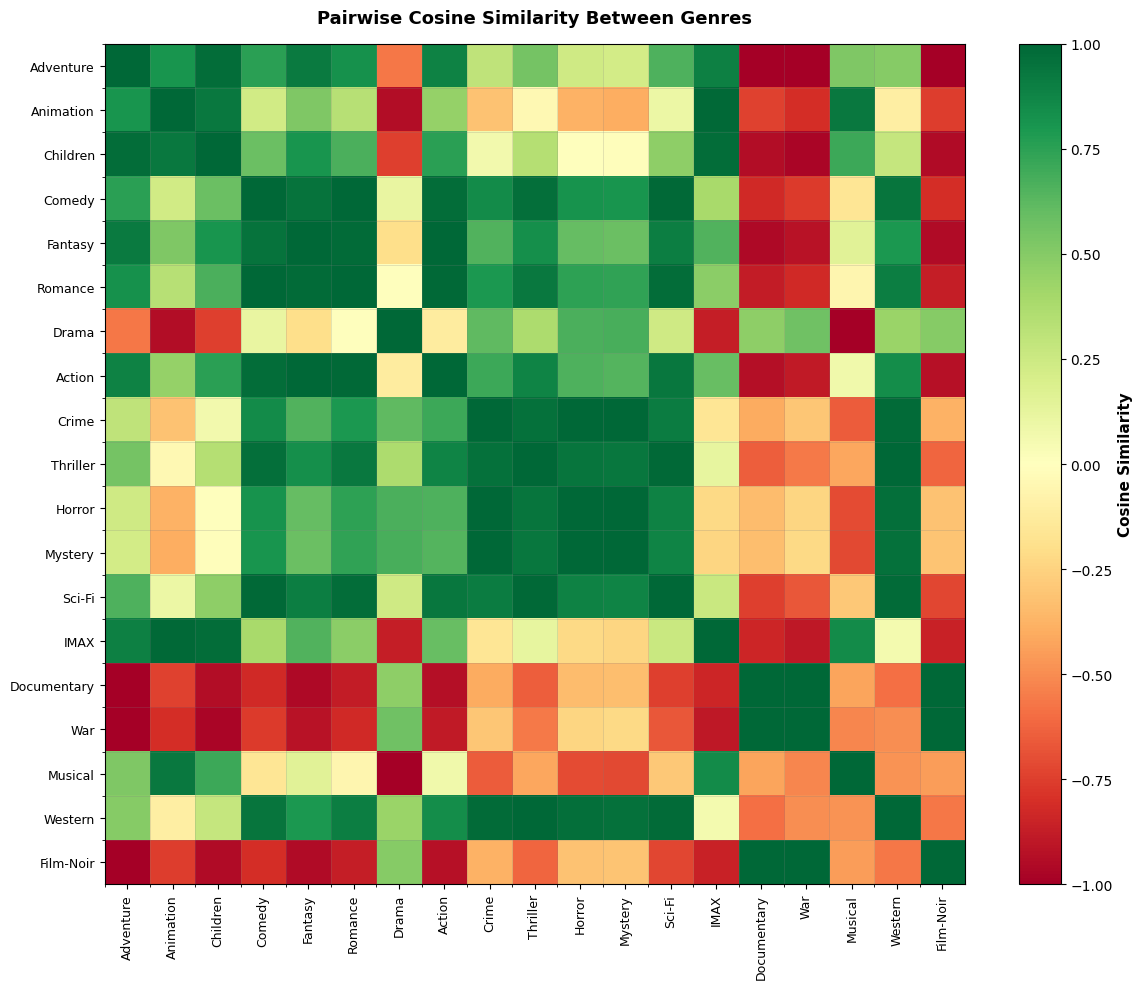

In [ ]:
_, cos_sim = dataset.plot_cosine_similarity_heatmap(
    save_dir=f"{save_folder}",
    save_name="genre_cosine_similarity"
)

In [ ]:
import pandas as pd
cos_sim, similar_pairs, dissimilar_pairs = dataset.compute_genre_cosine_similarities(top_k=10)

similar_pairs_df = pd.DataFrame(similar_pairs)
similar_pairs_df.to_csv(f'{save_folder}/similar_genre_pairs.csv')

dissimilar_pairs_df = pd.DataFrame(dissimilar_pairs)
dissimilar_pairs_df.to_csv(f'{save_folder}/dissimilar_genre_pairs.csv')

# Access the results programmatically
print(f"Horror and Thriller similarity: {similar_pairs[0][2]:.4f}")

Horror and Thriller similarity: 0.9999


In [ ]:
print(f"Similar Genre Pairs")
similar_pairs_df

Similar Genre Pairs


0          1         2
0       Horror    Mystery  0.999889
1  Documentary  Film-Noir  0.999663
2        Crime     Horror  0.997779
3     Thriller    Western  0.997698
4      Fantasy     Action  0.996777
5        Crime    Mystery  0.996677
6          War  Film-Noir  0.996496
7       Comedy    Romance  0.994463
8  Documentary        War  0.993990
9      Romance     Action  0.992108

In [ ]:
print(f"Dissimilar Genre Pairs")
dissimilar_pairs_df

Dissimilar Genre Pairs


0            1         2
0  Adventure          War -0.999999
1      Drama      Musical -0.998737
2  Adventure    Film-Noir -0.996350
3  Adventure  Documentary -0.993799
4   Children          War -0.971955
5    Fantasy  Documentary -0.958655
6    Fantasy    Film-Noir -0.950946
7   Children    Film-Noir -0.948881
8  Animation        Drama -0.941657
9   Children  Documentary -0.940369

In [ ]:
! zip -r AMLAS_Experiments.zip  experiments/

from google.colab import files
files.download('AMLAS_Experiments.zip')

updating: experiments/ (stored 0%)
updating: experiments/v1.1/ (stored 0%)
updating: experiments/v1.1/pdfs/ (stored 0%)
updating: experiments/v1.1/pdfs/bias_updates_test_performance.pdf (deflated 35%)
updating: experiments/v1.1/pdfs/bias_updates_train+val_performance.pdf (deflated 34%)
updating: experiments/v1.1/optimizedTrainer_history.npz (deflated 48%)
updating: experiments/v1.1/model_(hyper)parameters_optimizedTrainer.npz (deflated 6%)
updating: experiments/v1.1/v1.1.yaml (deflated 42%)
updating: experiments/v1.1/pngs/ (stored 0%)
updating: experiments/v1.1/pngs/bias_updates_test_performance.pngs (deflated 30%)
updating: experiments/v1.1/pngs/bias_updates_train+val_performance.png (deflated 20%)
updating: experiments/v1.1/pdfs/polarization+movie_names.pdf (deflated 1%)
updating: experiments/v1.1/pdfs/dummy_user_recommendations_LOR.pdf (deflated 4%)
updating: experiments/v1.1/pdfs/polarization_embedding_norms+rating_variances.pdf (deflated 2%)
updating: experiments/v1.1/pdfs/polariz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>